In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

dataset   zipper kinase model
0     E+E      E+E     wt  push
1     I+E      I+E     wt  push
2    RR+A     RR+A     wt  push
3     S+A      S+A     wt  push
4     S+E      S+E     wt  push
5      wt  generic     wt  push
6      KD  generic     KD  push
7   R460A  generic  R460A  push
8   R460K  generic  R460K  push
9   R460S  generic  R460S  push

183583
183583


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                
E+E     0      5993.989258  6394.181152   8649.121094          1.352655
        1       484.283875   664.000793    564.378601          0.849967
        2       605.894165   737.394714     91.147232          0.123607
        3       803.416565   333.886597    168.033020          0.503264
        4      3100.157715   131.973206     60.481567          0.458287
...                    ...          ...           ...               ...
R460S   16545  5309.096680  1487.364502    111.186920          0.074754
        16546   789.222717   317.242950    186.230530          0.587028
        16547  2344.962402  2284.269287    515.575562          0.225707
        16548  8778.976562  4125.944824    111.947510          0.027133
        16549   837.460266  1159.818726     78.997864          0.068112

[183583 rows x 4 columns]

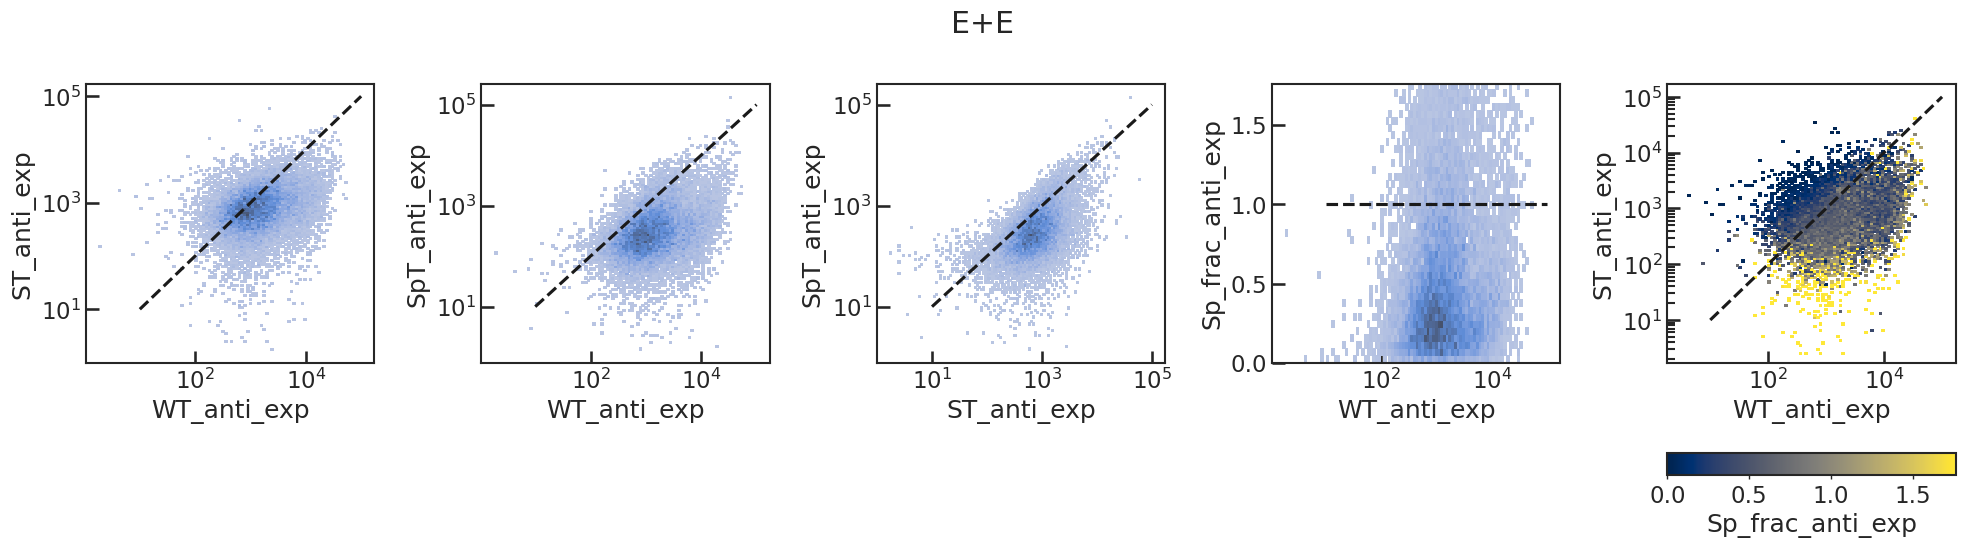

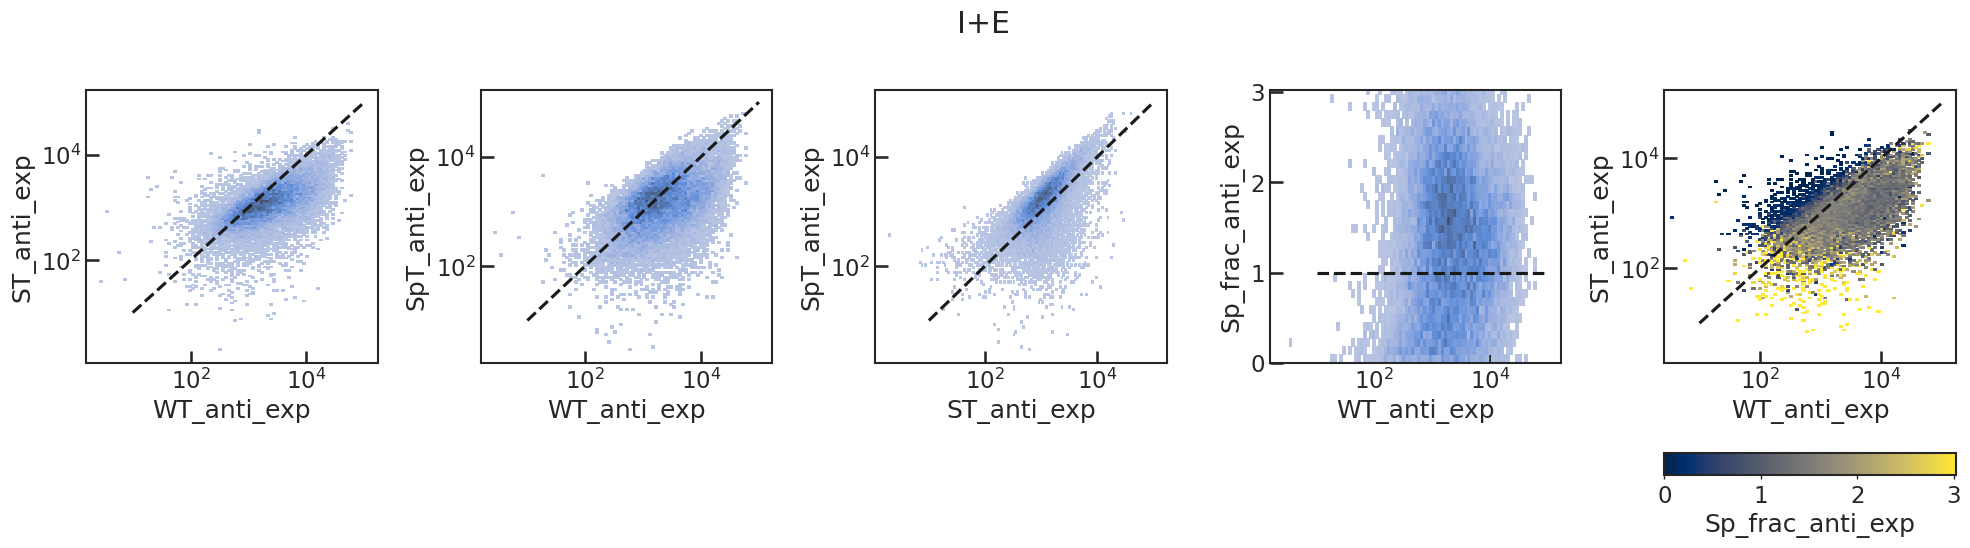

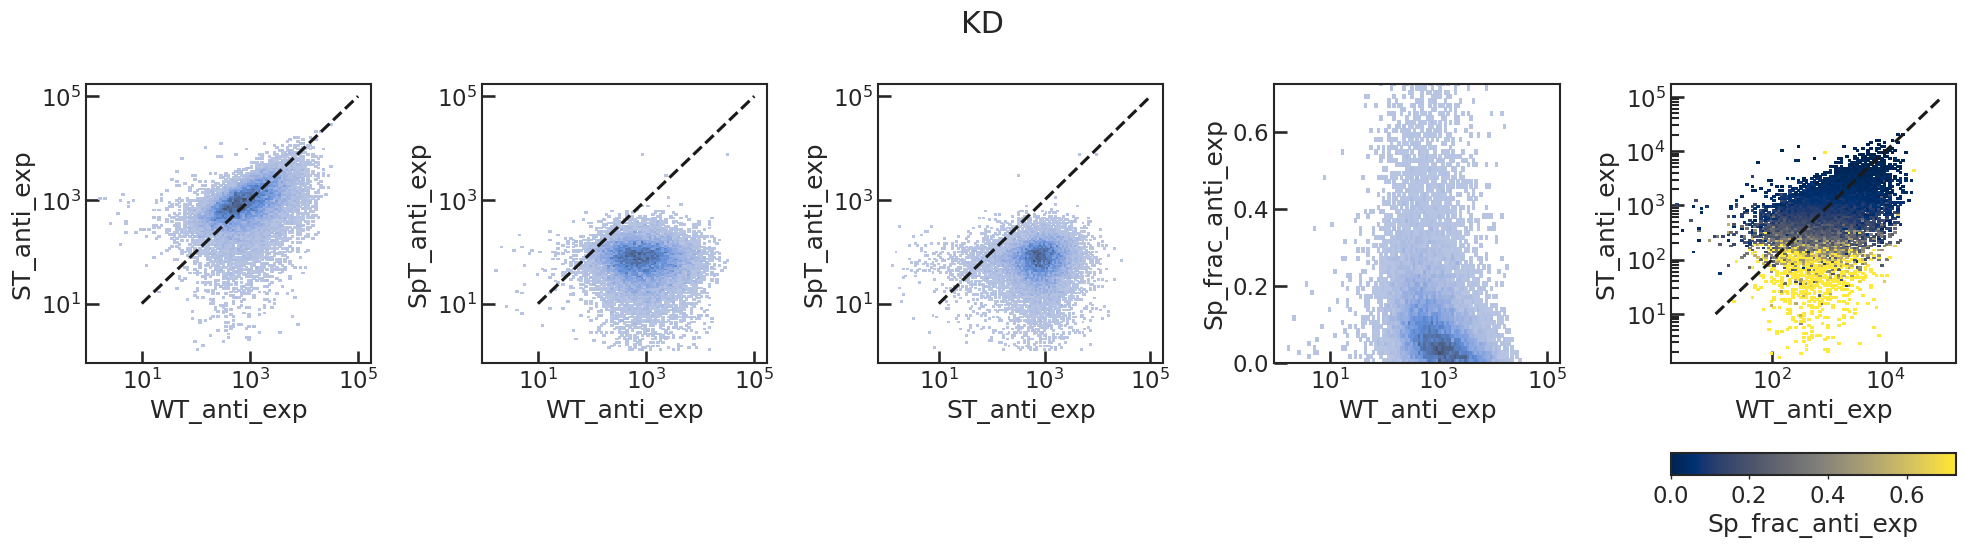

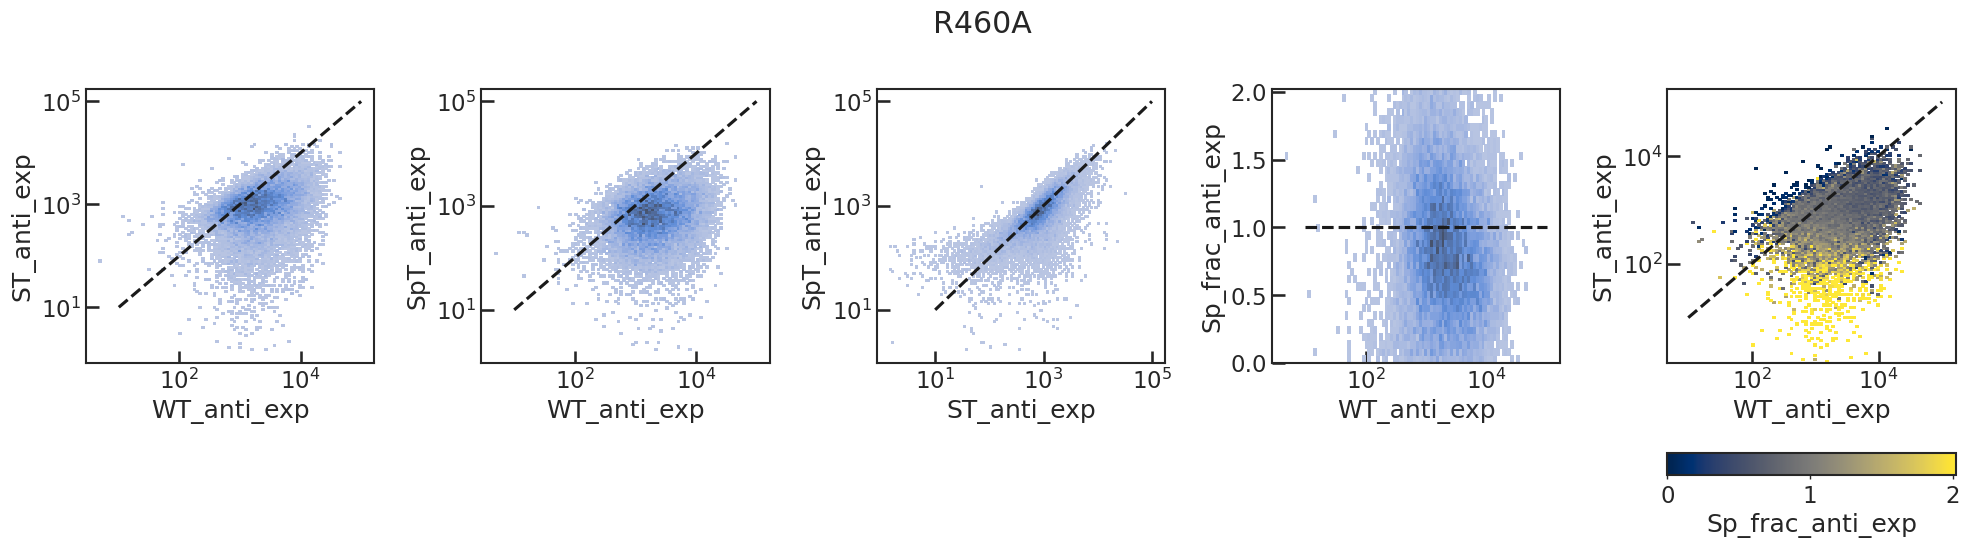

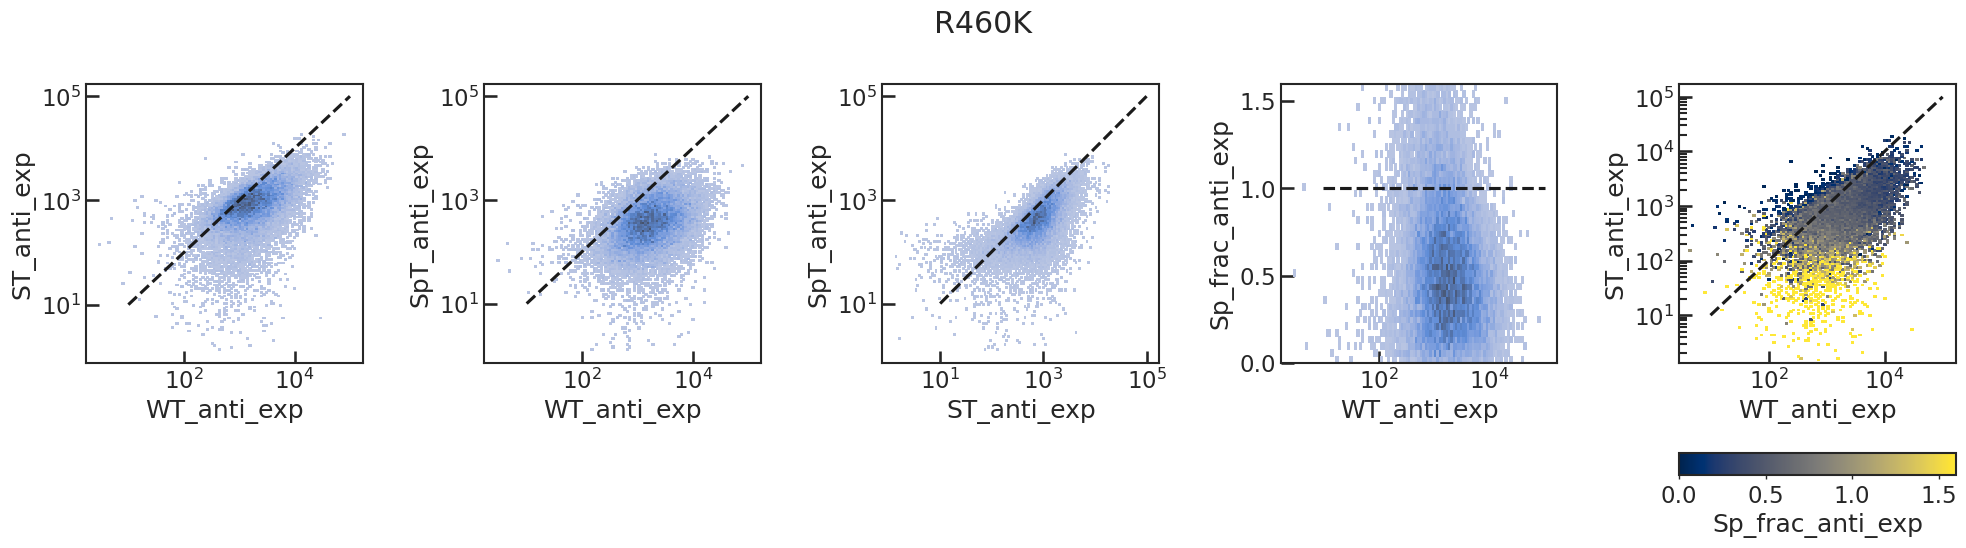

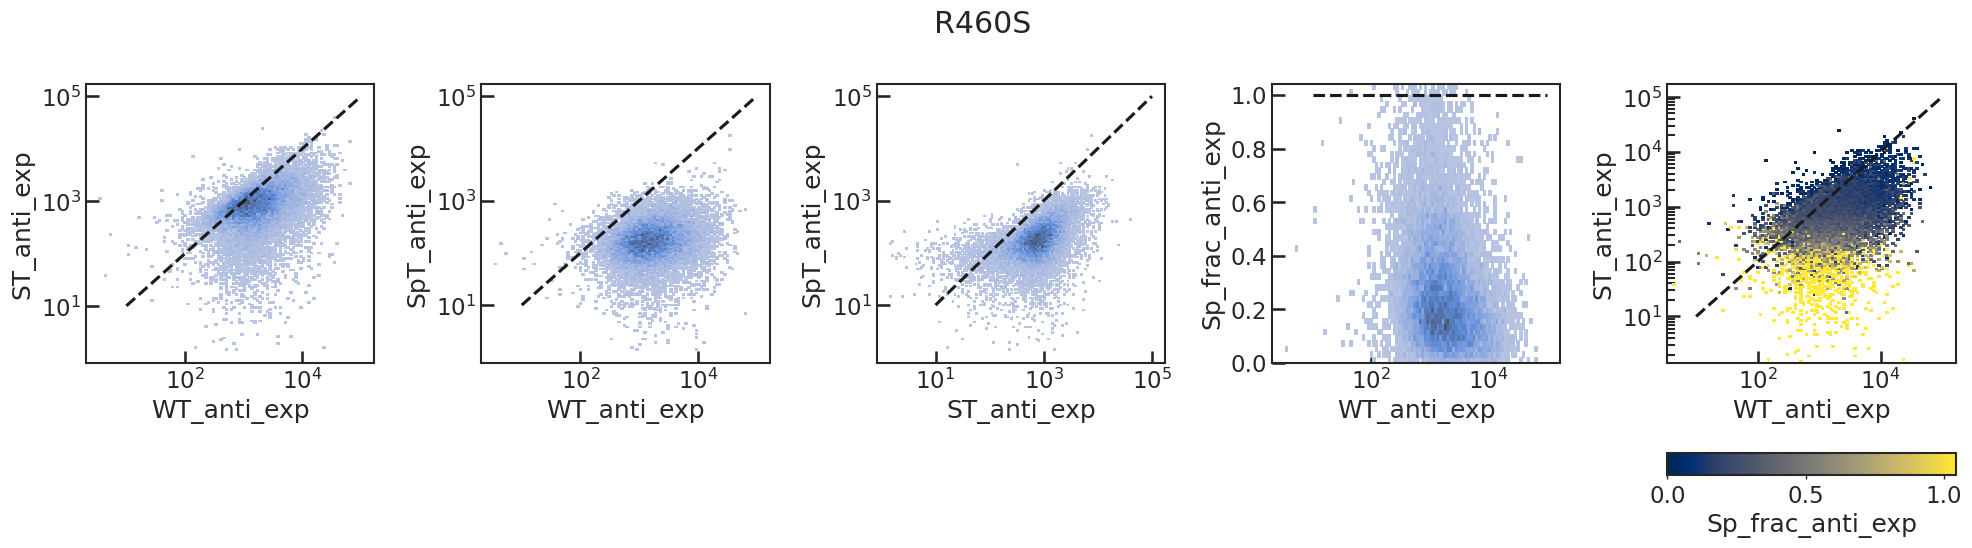

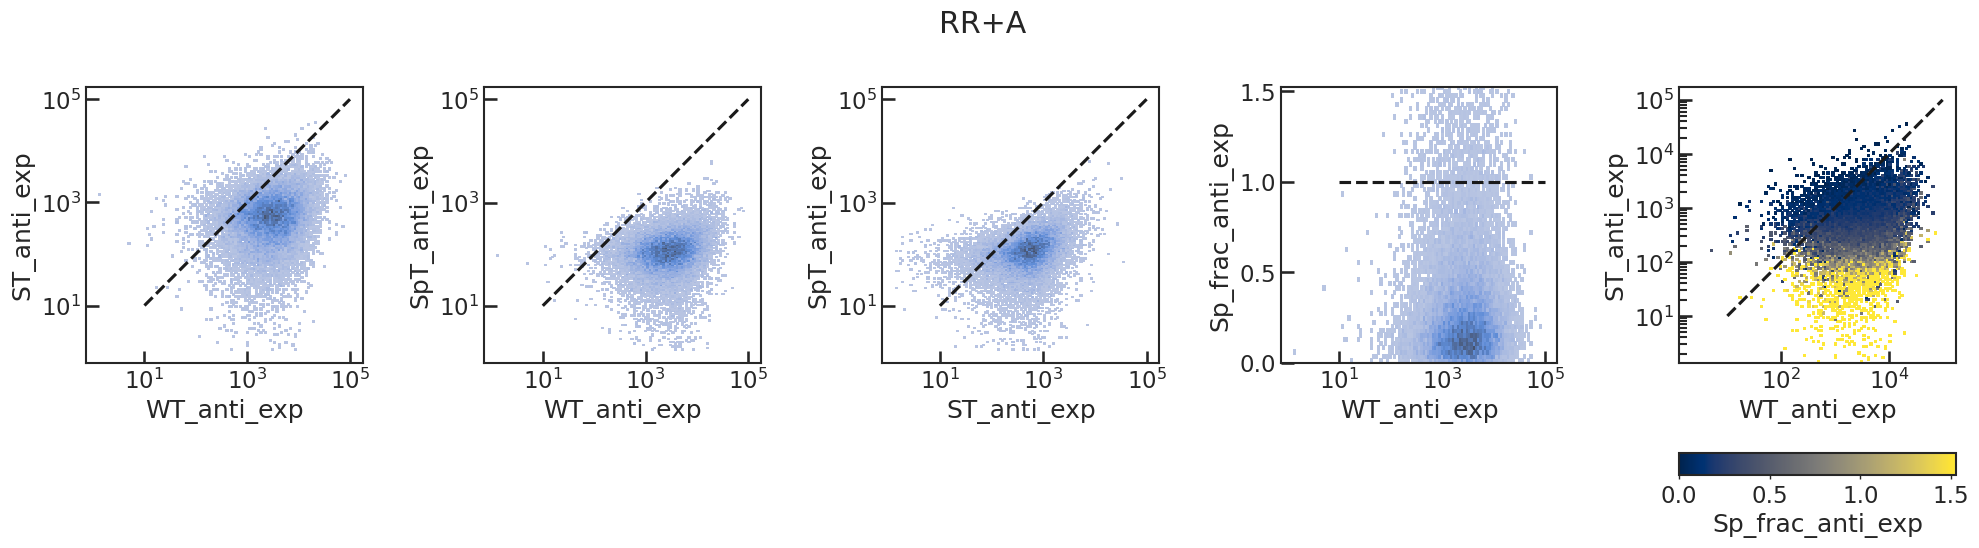

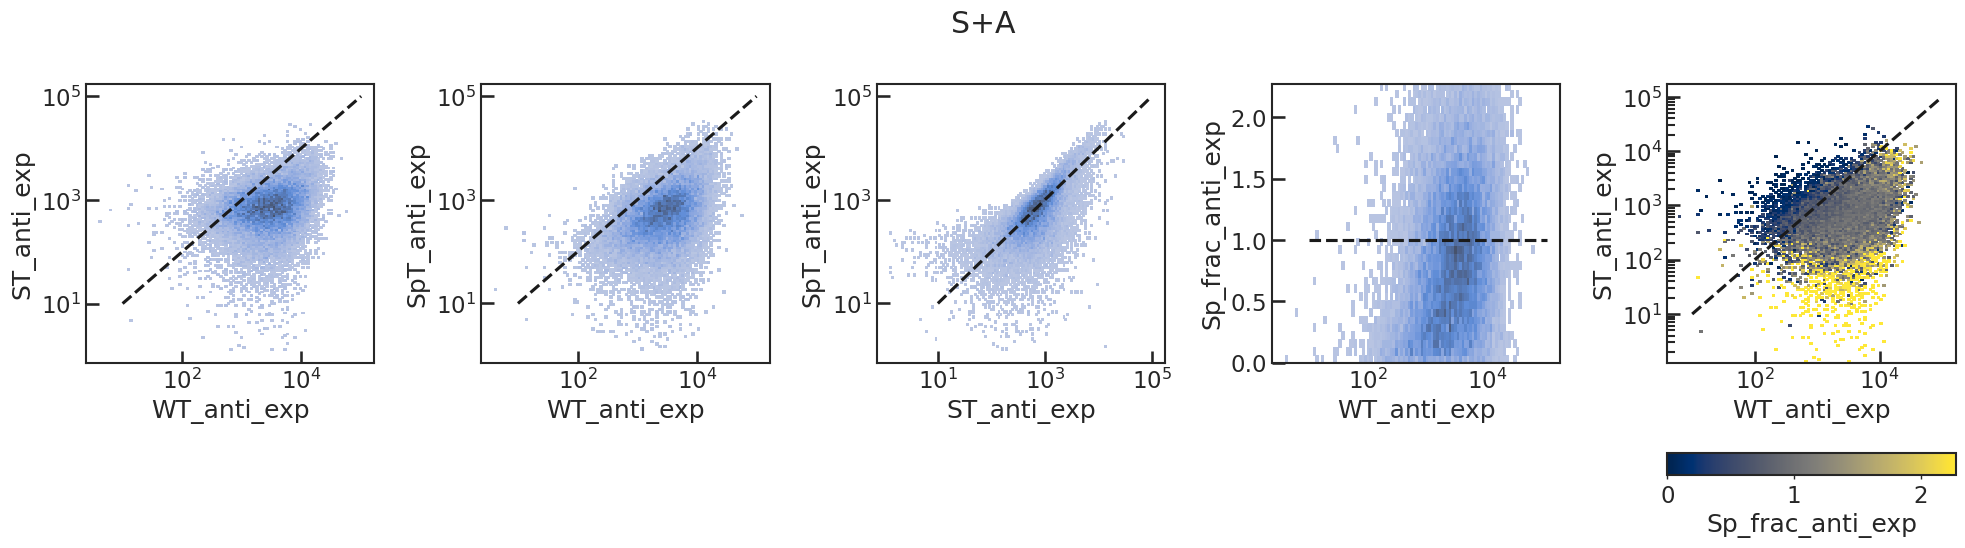

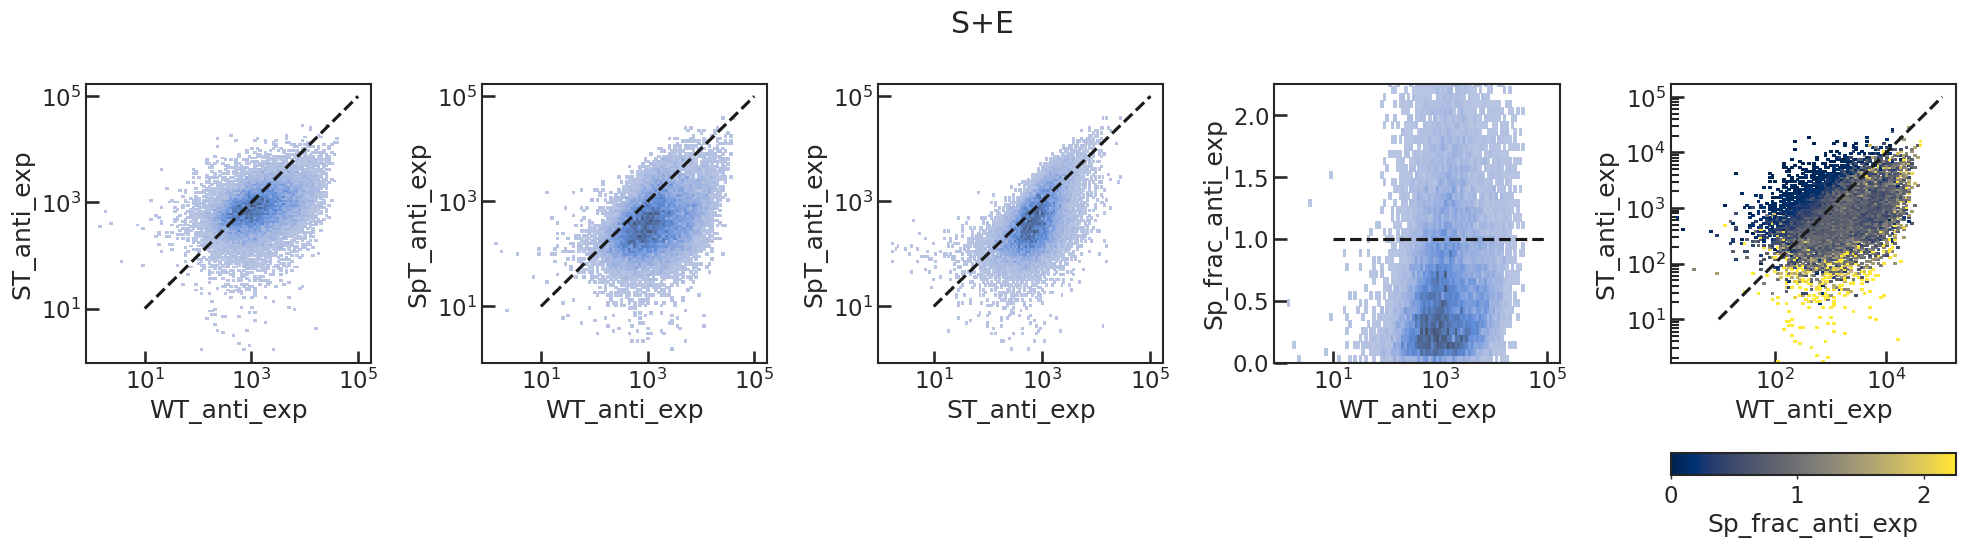

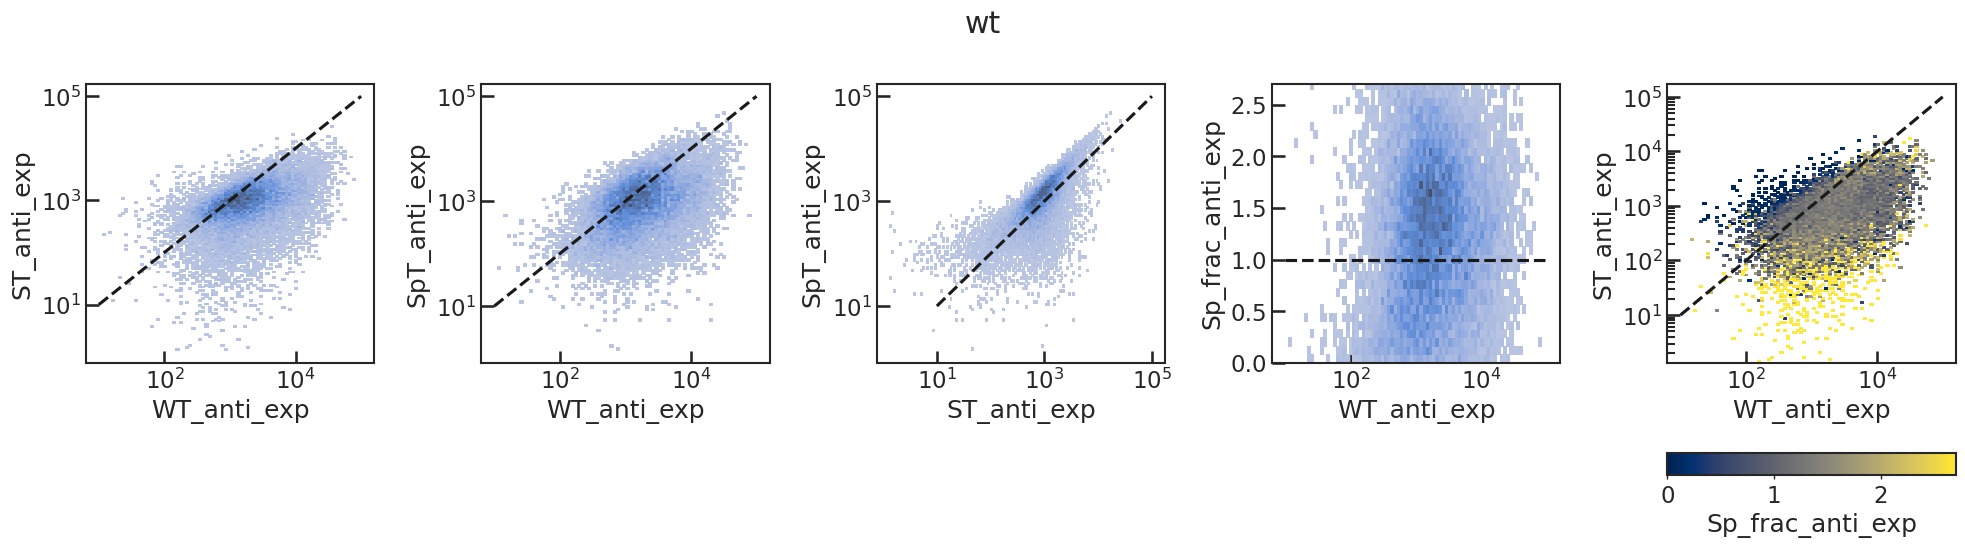

In [47]:


# dataset, zipper variant, kinase variant, model
s_list = [
    ['E+E', 'E+E', 'wt', 'push'],
    ['I+E', 'I+E', 'wt', 'push'],
    ['RR+A', 'RR+A', 'wt', 'push'],
    ['S+A', 'S+A', 'wt', 'push'],
    ['S+E', 'S+E', 'wt', 'push'],
    ['wt', 'generic', 'wt', 'push'],
    ['KD', 'generic', 'KD', 'push'],
    ['R460A', 'generic', 'R460A', 'push'],
    ['R460K', 'generic', 'R460K', 'push'],
    ['R460S', 'generic', 'R460S', 'push'],
         ]

df_info = pd.DataFrame(s_list, columns=['dataset', 'zipper', 'kinase', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/push_data/{}.csv".format(row['dataset']))    
    df['dataset'] = row['dataset']      
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


print(len(df.index))
df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})
print(len(df.index))

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']



display(df)


for i, (dataset, group) in enumerate(df.groupby("dataset")):

    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))

    
    fig.suptitle(dataset)
    
    ax = axes[0]
    
    sns.histplot(group, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[1]
    
    sns.histplot(group, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    
    ax = axes[2]
    
    sns.histplot(group, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[3]
        
    
    sns.histplot(group, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, group['Sp_frac_anti_exp'].quantile(0.95))
    
    
    ax = axes[4]
    
    
    hist, xedges = np.histogram(np.log10(group['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(group['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp = group.copy()
    
    df_tmp['xbin'] = pd.cut(group['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(group['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
        
    
    
    plt.tight_layout()
    
    
    
    bbox = ax.get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")

    

    plt.show()
    
    


Num Cells: 6460 Points per bin: 10 Num Bins: 25
Num Cells: 12085 Points per bin: 10 Num Bins: 34


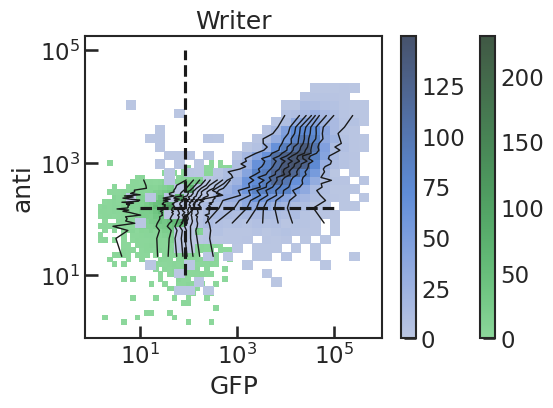

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


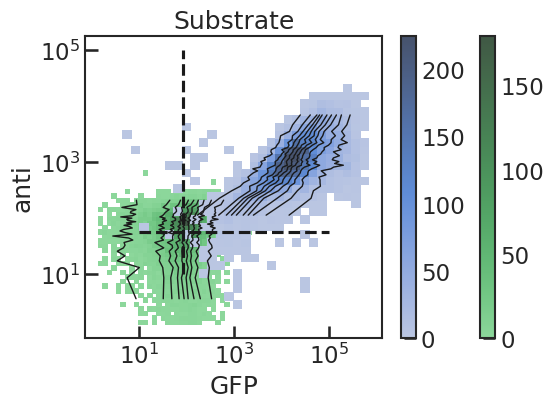

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


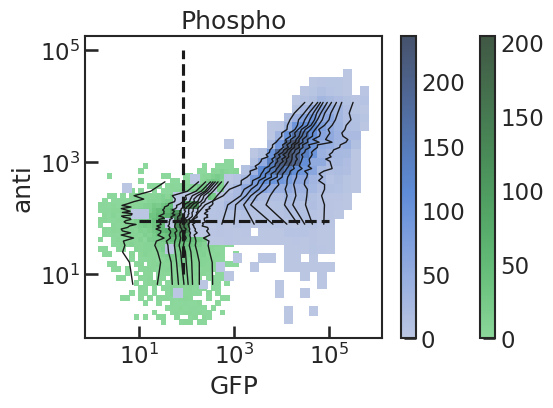

Num Cells: 8469 Points per bin: 10 Num Bins: 29


anti           GFP  anti_bin  GFP_bin
0      3667.152344  22898.355470        24        6
1       476.868988   5922.267578         5       12
2        23.291704  14411.395510         0       16
3      1000.184021  26463.156250        12       21
4      1305.120117  56764.875000        15       25
...            ...           ...       ...      ...
20549   107.773010     99.154053        19       18
20550    95.165207     35.085114        16        6
20551   103.868874     76.818558        18       14
20552   151.937317    101.059883        25       17
20553    43.166561     43.098728         5        6

[20554 rows x 4 columns]

Num Cells: 20554 Points per bin: 10 Num Bins: 45


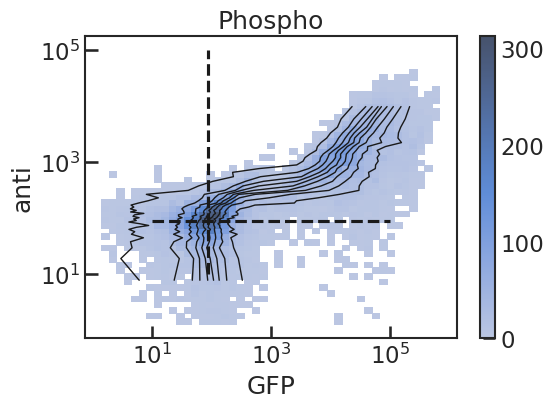

Num Cells: 8469 Points per bin: 10 Num Bins: 29
Num Cells: 12085 Points per bin: 10 Num Bins: 34


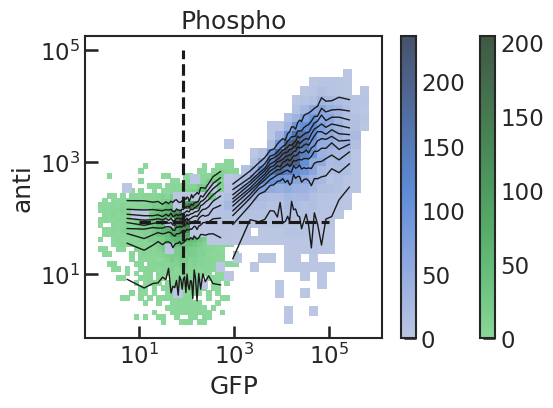

GFP         anti  GFP_bin  anti_bin
0      22898.355470  3667.152344       15        24
1       5922.267578   476.868988        4         6
2      14411.395510    23.291704       11         0
3      26463.156250  1000.184021       17         8
4      56764.875000  1305.120117       23         8
...             ...          ...      ...       ...
20549     99.154053   107.773010       17        20
20550     35.085114    95.165207        5        19
20551     76.818558   103.868874       13        22
20552    101.059883   151.937317       17        27
20553     43.098728    43.166561        6         5

[20554 rows x 4 columns]

Num Cells: 20554 Points per bin: 10 Num Bins: 45


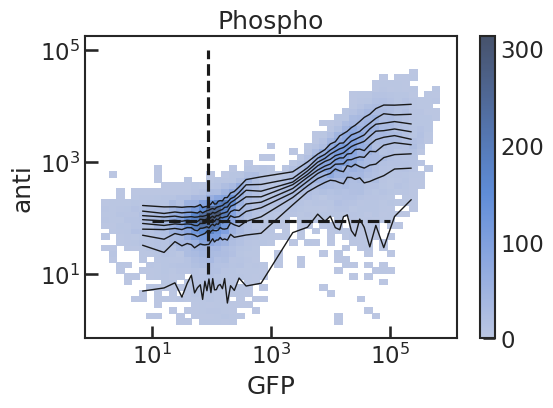

In [66]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.Anti2GFPNoise("../data/noise_data/Flag noise.csv", 
                                   'HA', 'GFP', ppbin=10, verbose=False)

empty_writer_noise = noise.Anti2GFPNoise("../data/noise_data/Empty Cell.csv", 
                                   'HA', 'GFP', ppbin=10, verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.Anti2GFPNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Myc', 'GFP', ppbin=10, verbose=False)

empty_substrate_noise = noise.Anti2GFPNoise("../data/noise_data/Empty Cell.csv", 
                                   'Myc', 'GFP', ppbin=10, verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.Anti2GFPNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

empty_phospho_noise = noise.Anti2GFPNoise("../data/noise_data/Empty Cell.csv", 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


combined_phospho_noise = noise.Anti2GFPNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Phospho', 'GFP', ppbin=10, verbose=False)
combined_phospho_noise.add_cells(empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
combined_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



inverse_phospho_noise = noise.GFP2AntiNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

inverse_empty_phospho_noise = noise.GFP2AntiNoise("../data/noise_data/Empty Cell.csv", 
                                   'GFP', 'Phospho', ppbin=10, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

inverse_empty_phospho_noise.plot(ax, color='g')
inverse_phospho_noise.plot(ax)
ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



inverse_phospho_noise.add_cells(inverse_empty_phospho_noise)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
inverse_phospho_noise.plot(ax)

ax.set_title("Phospho")

ax.hlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(inverse_empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()



0.05694438975603727 [0.05       0.20017895] 0
0.0424748564250218 [0.01327777 0.20017895] 0
0.04204292047912028 [0.00807197 0.20017895] 0
0.04179854936288552 [0.00512675 0.20017895] 0
0.040005782520933786 [0.00512675 0.23495714] 0
0.0380961557321491 [0.04682409 0.23495714] 0
0.035243199648897924 [0.04211649 0.23495714] 0
0.03342071037679095 [0.03494062 0.23495714] 0
0.03302946785980965 [0.02741851 0.23495714] 0
0.03263310679833653 [0.019798   0.23495714] 0
0.03194882695002854 [0.03255559 0.23987933] 0
0.031902238096586544 [0.03168323 0.23987933] 0
0.031887281697098424 [0.03140318 0.23987933] 0
0.03143746893286381 [0.03140318 0.2416365 ] 0
0.03143746893286359 [0.03140318 0.24157376] 0
0.031152218126960507 [0.03456217 0.24334321] 0
0.03100984901263093 [0.03456217 0.24285176] 0
0.031009849012630708 [0.03456217 0.24287807] 0
0.031009849012630042 [0.03456217 0.24279024] 0
0.030944840561372255 [0.0388303  0.24544821] 0
0.030928189479893398 [0.03852645 0.24544821] 0
0.030928189479892843 [0.038

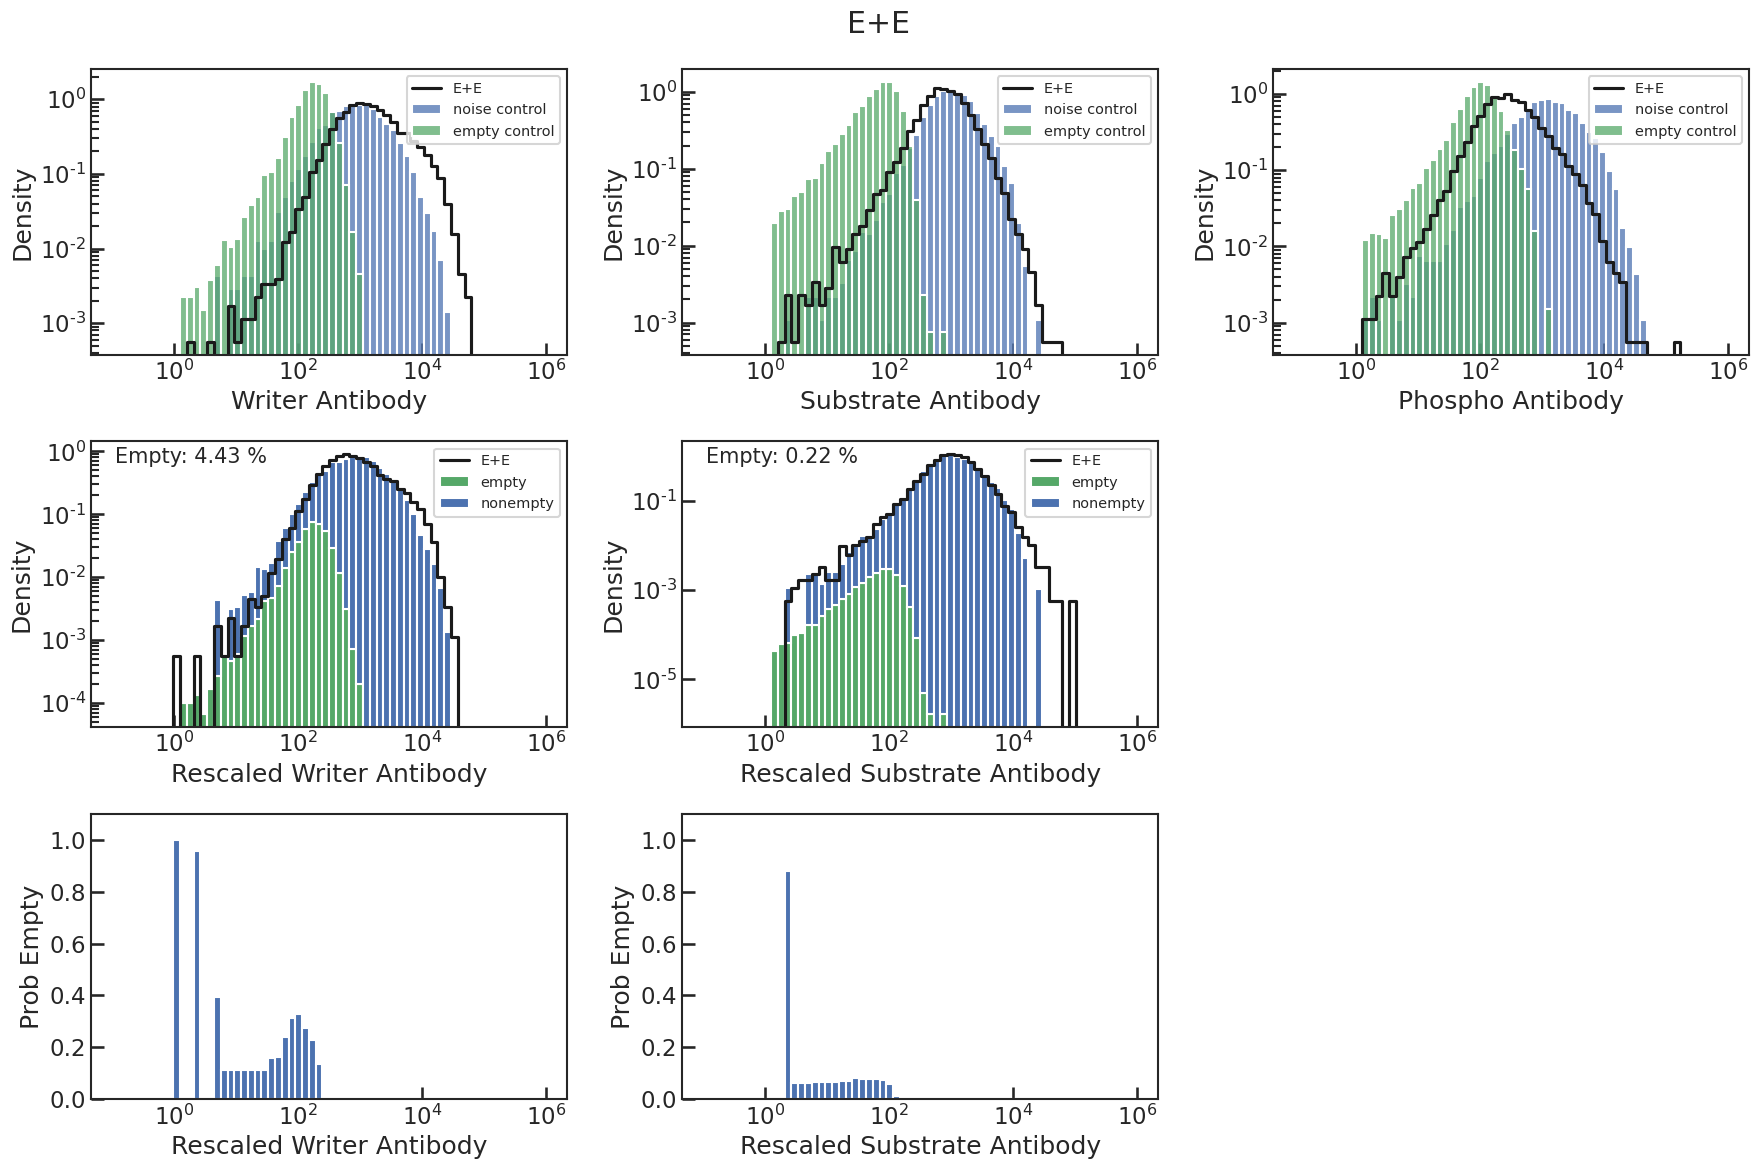

0.058616216664537535 [0.11397454 0.41365191] 0
0.049056385789357226 [0.09163806 0.41365191] 0
0.04333022507179762 [0.22017238 0.55397429] 0
0.04079097981324631 [0.16593613 0.55397429] 0
0.03613062963699376 [0.17428624 0.55397429] 0
0.03516903848058239 [0.17600915 0.55397429] 0
0.027169507786329206 [0.19034218 0.55397429] 0
0.021291310228779253 [0.13047058 0.50038697] 0
0.02115536720519451 [0.12829619 0.50038697] 0
0.020855251505751626 [0.12883052 0.50038697] 0
0.019800918454308813 [0.11801088 0.4897618 ] 0
0.019254957012908608 [0.11138892 0.48250301] 0
0.019227257231710038 [0.10636988 0.48250301] 0
0.018624439301065998 [0.10744566 0.48250301] 0
0.018601071227177357 [0.10978051 0.48250301] 0
0.0180580595046671 [0.10978051 0.48373891] 0
0.01803255520889202 [0.11022426 0.48373891] 0
0.01802016534576878 [0.11013902 0.48373891] 0
0.01799966492411309 [0.10999798 0.48373891] 0
0.01799966492411298 [0.10999798 0.48367722] 0
0.017997888713737198 [0.10998576 0.4836023 ] 0
0.0179978887137362 [0.10

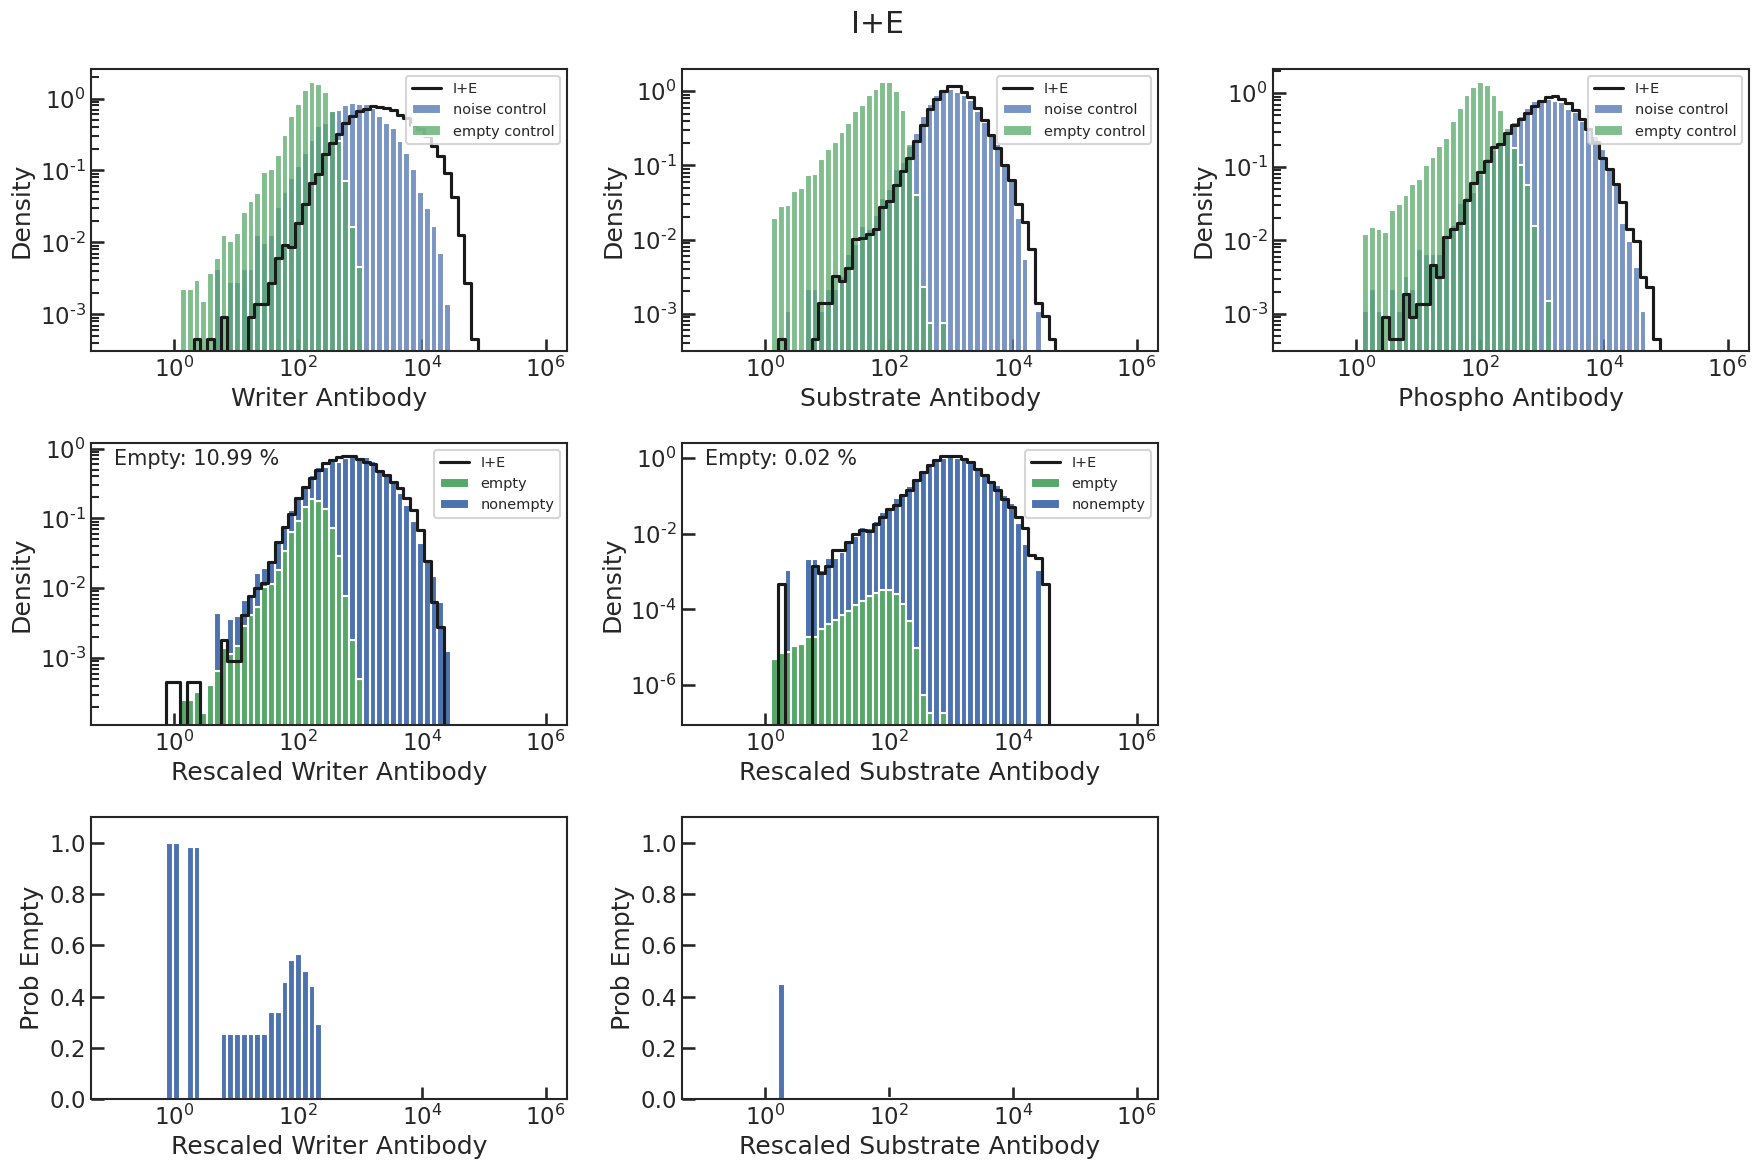

0.021620387165714794 [0.00260818 0.        ] 0
0.01913492731596385 [0.00260818 0.00786204] 0
0.01820114277097523 [0.00106763 0.00786204] 0
0.017820478383228033 [0.00043961 0.00786204] 0
0.017547258031658852 [0.00043961 0.00848126] 0
0.01726583608130322 [0.00094052 0.00848126] 0
0.017249696387499402 [0.00096924 0.00848126] 0
0.017242150041891002 [0.00098268 0.00848126] 0
0.017242150041890947 [0.00098268 0.00843851] 0
0.01721434929557293 [0.00119925 0.00843851] 0
0.017186252994328993 [0.00115291 0.00843851] 0
0.01714650618528374 [0.00115291 0.00866459] 0
0.01708082540711575 [0.00126982 0.00866459] 0
0.017001191504455337 [0.00141156 0.00866459] 0
0.017001191504455282 [0.00141156 0.00861349] 0
     fun: 0.017001191504455282
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
     nit: 2000
    njev: 0
  status: 0
 success: True
       x: array([0.00141156, 0.00861349])
0.08492392103226012 [0.14809993 0.        ] 0
0.060694950629391675 [ 0.04612352 -0.06678538] 0
0.

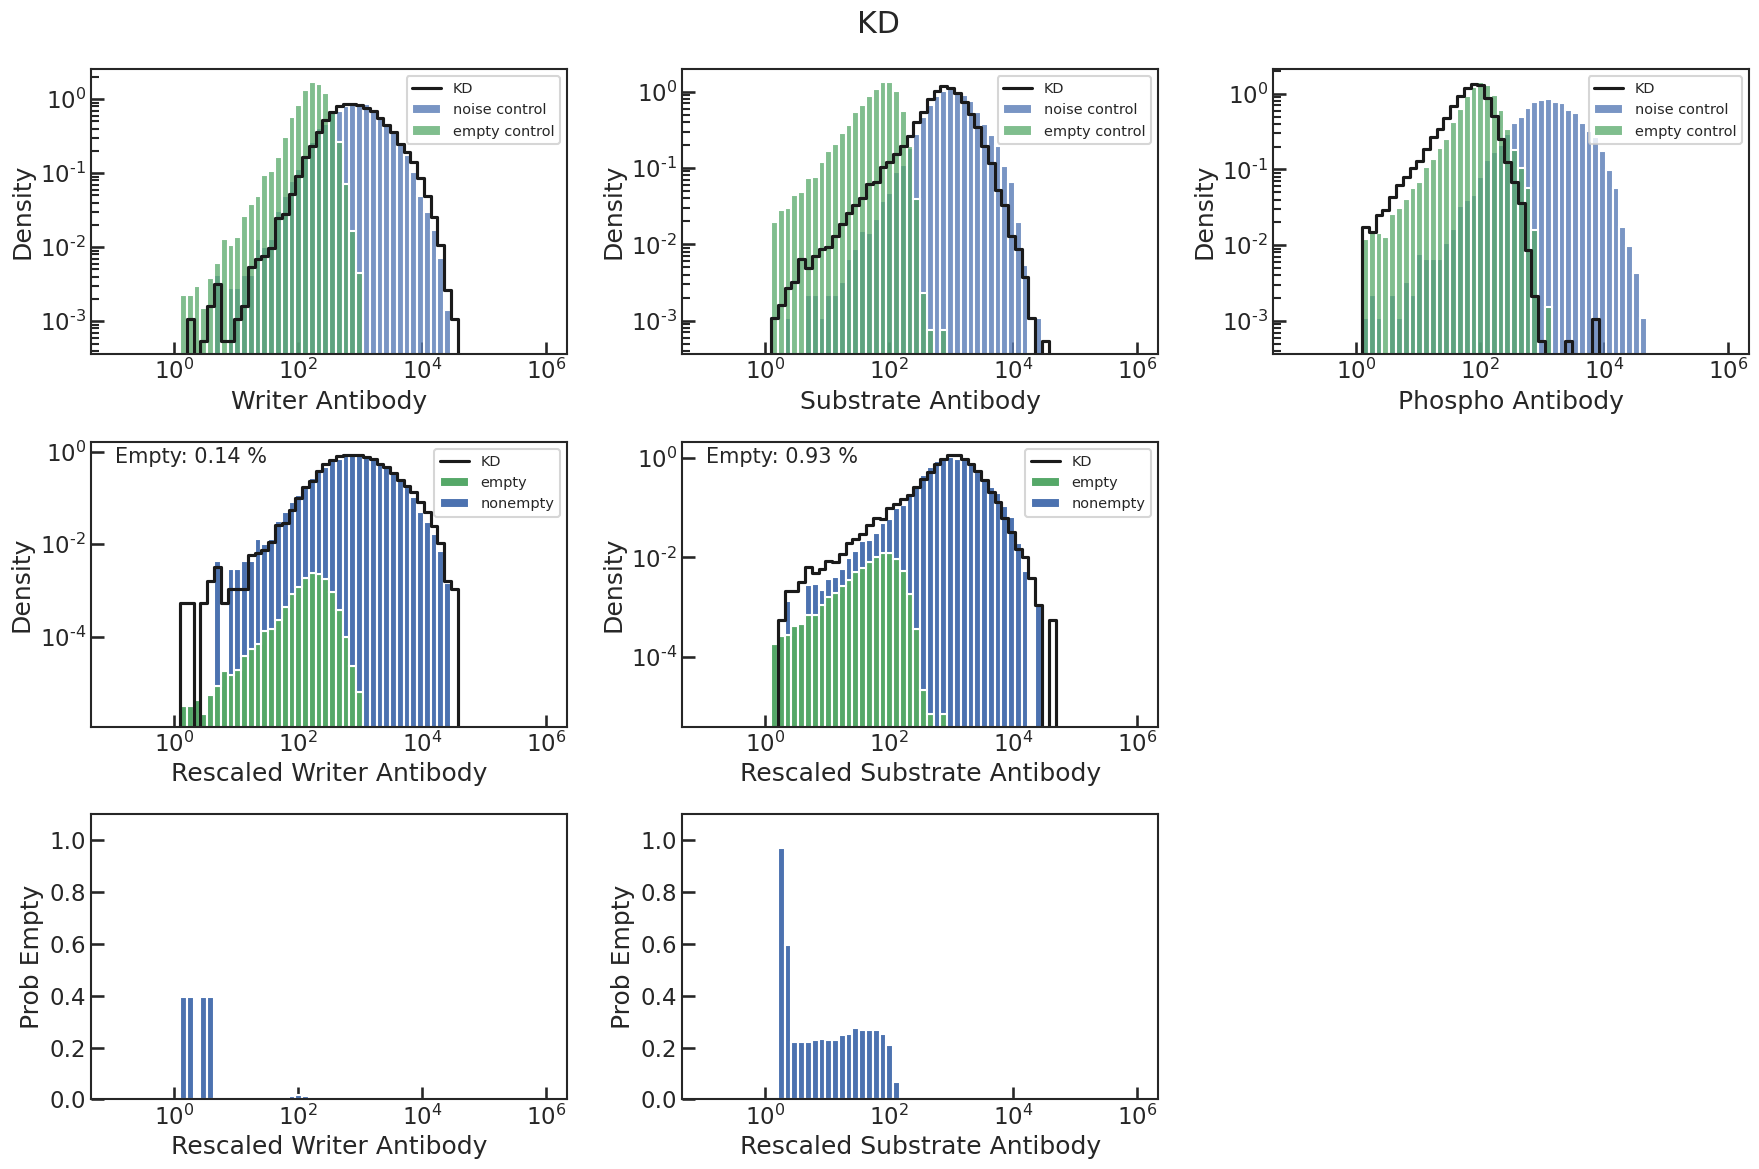

0.34822868011790215 [0.05313203 0.00313203] 0
0.33221083651492184 [0.01001733 0.00313203] 0
0.2759916973282076 [0.01070741 0.06925768] 0
0.12394810953799551 [0.00192011 0.51139958] 0
0.08818460127922145 [0.07064939 0.51139958] 0
0.07691190831283301 [0.09823332 0.51139958] 0
0.049576394987038364 [0.05139742 0.45187461] 0
0.048742295892762036 [0.05768418 0.42144796] 0
0.03394464927570828 [0.03225186 0.42144796] 0
0.033611566545098795 [0.03225186 0.42019883] 0
0.03314937053892625 [0.01310426 0.39498213] 0
0.025204814246113122 [1.26301023e-04 3.94982133e-01] 0
0.025204814246113094 [1.26301023e-04 3.94555928e-01] 0
0.024954610955939857 [1.26301023e-04 3.95300196e-01] 0
0.024892060133396537 [1.26301023e-04 3.95545357e-01] 0
0.024829509310853218 [1.26301023e-04 3.95666713e-01] 0
0.024769920634192352 [2.89589456e-05 3.95666713e-01] 0
0.02476992063419234 [2.89589456e-05 3.95607145e-01] 0
     fun: 0.02476992063419234
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
 

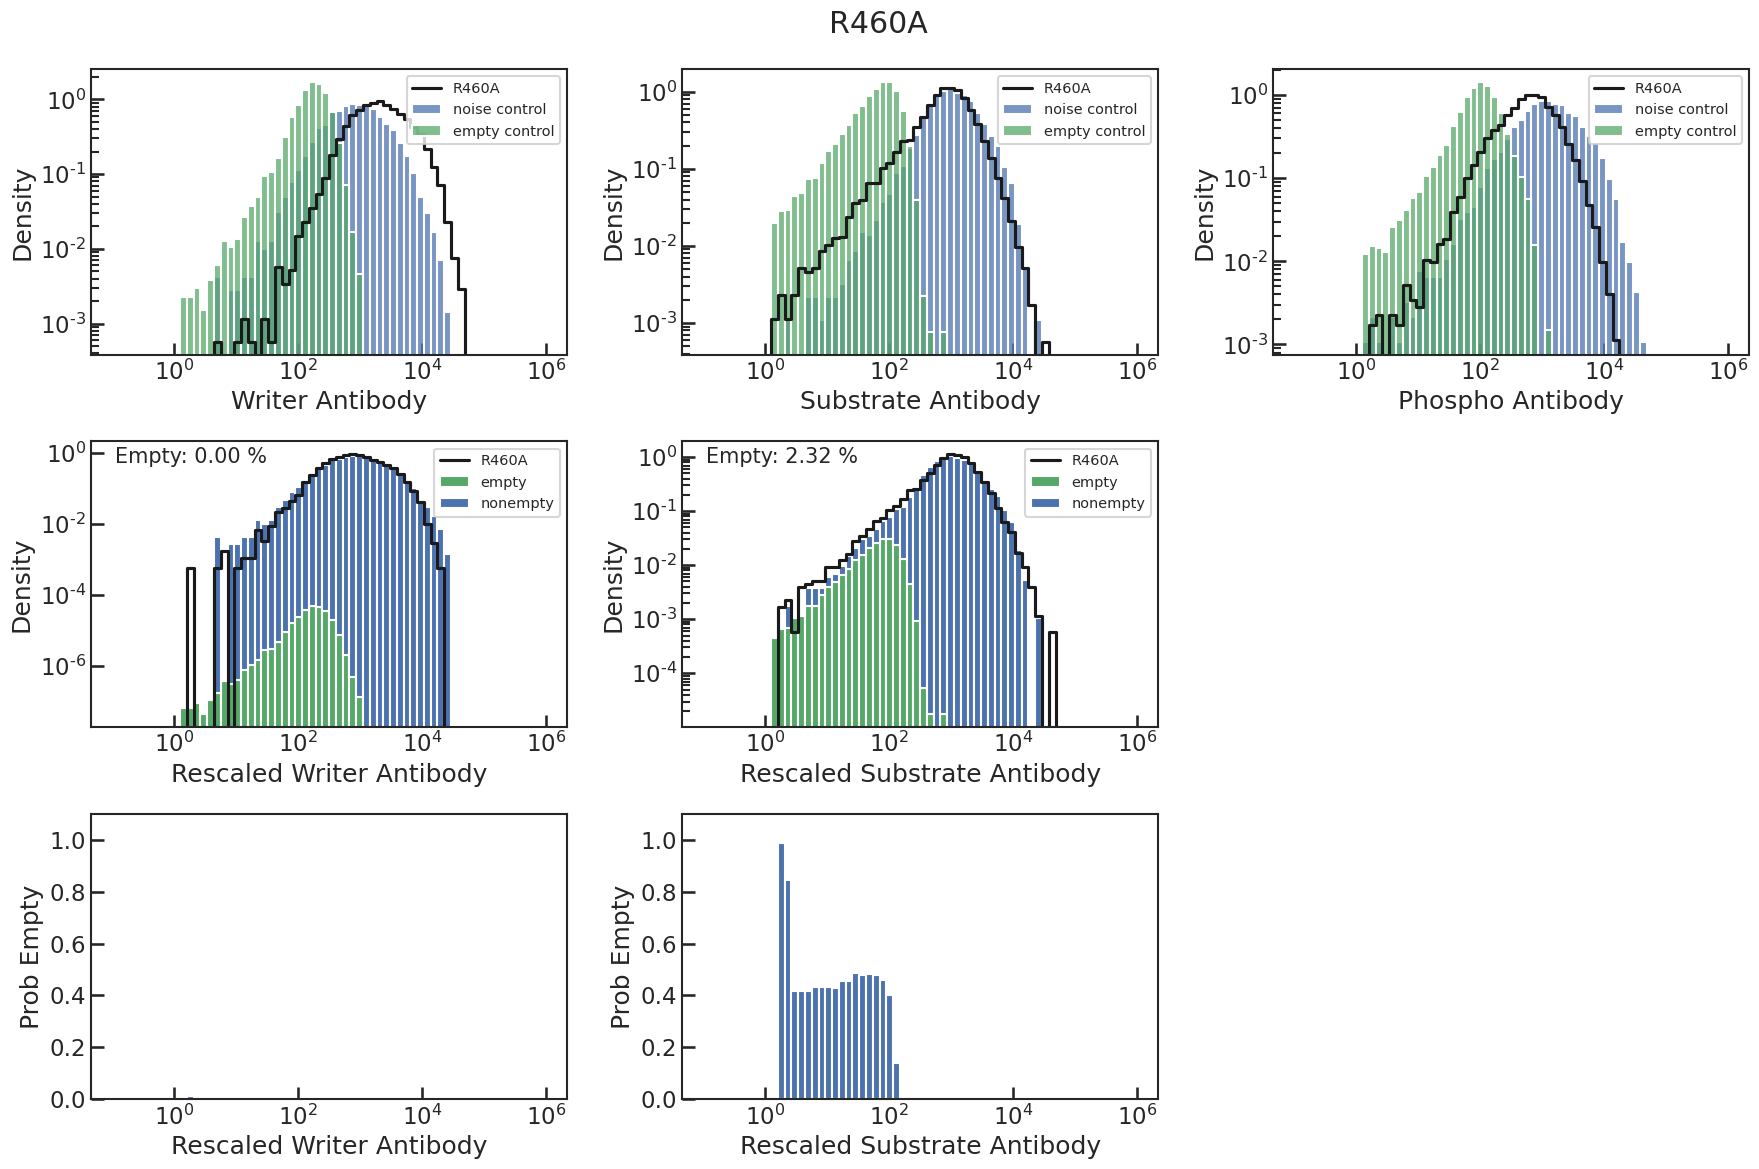

0.043616621754114404 [0.06373529 0.33824745] 0
0.04133337999545689 [0.06000546 0.33824745] 0
0.03509068054011946 [0.02387284 0.30211483] 0
0.03406757247449094 [0.02220246 0.30211483] 0
0.033598485509542725 [0.0214366  0.30211483] 0
0.027908284129310318 [0.01214647 0.30211483] 0
0.027563014604457203 [0.00416007 0.30211483] 0
0.026978543522553244 [0.00555719 0.30211483] 0
0.02672616387741955 [0.00616049 0.30211483] 0
0.026161112706183487 [0.00927289 0.30211483] 0
0.025995632115438483 [0.00899996 0.30211483] 0
0.025804789401370987 [0.00836295 0.30211483] 0
0.02575157971647124 [0.00859743 0.30211483] 0
0.025695232343089333 [0.00239023 0.2933028 ] 0
0.024809083604557983 [0.00094306 0.2933028 ] 0
0.024273206092920024 [6.79225319e-05 2.93302795e-01] 0
0.02366066763574637 [6.79225319e-05 2.95217291e-01] 0
0.023634329947185062 [6.79225319e-05 2.95521810e-01] 0
0.023558941619949217 [6.79225319e-05 2.95473831e-01] 0
0.02354749409372435 [4.91842406e-05 2.95436747e-01] 0
     fun: 0.023547494093724

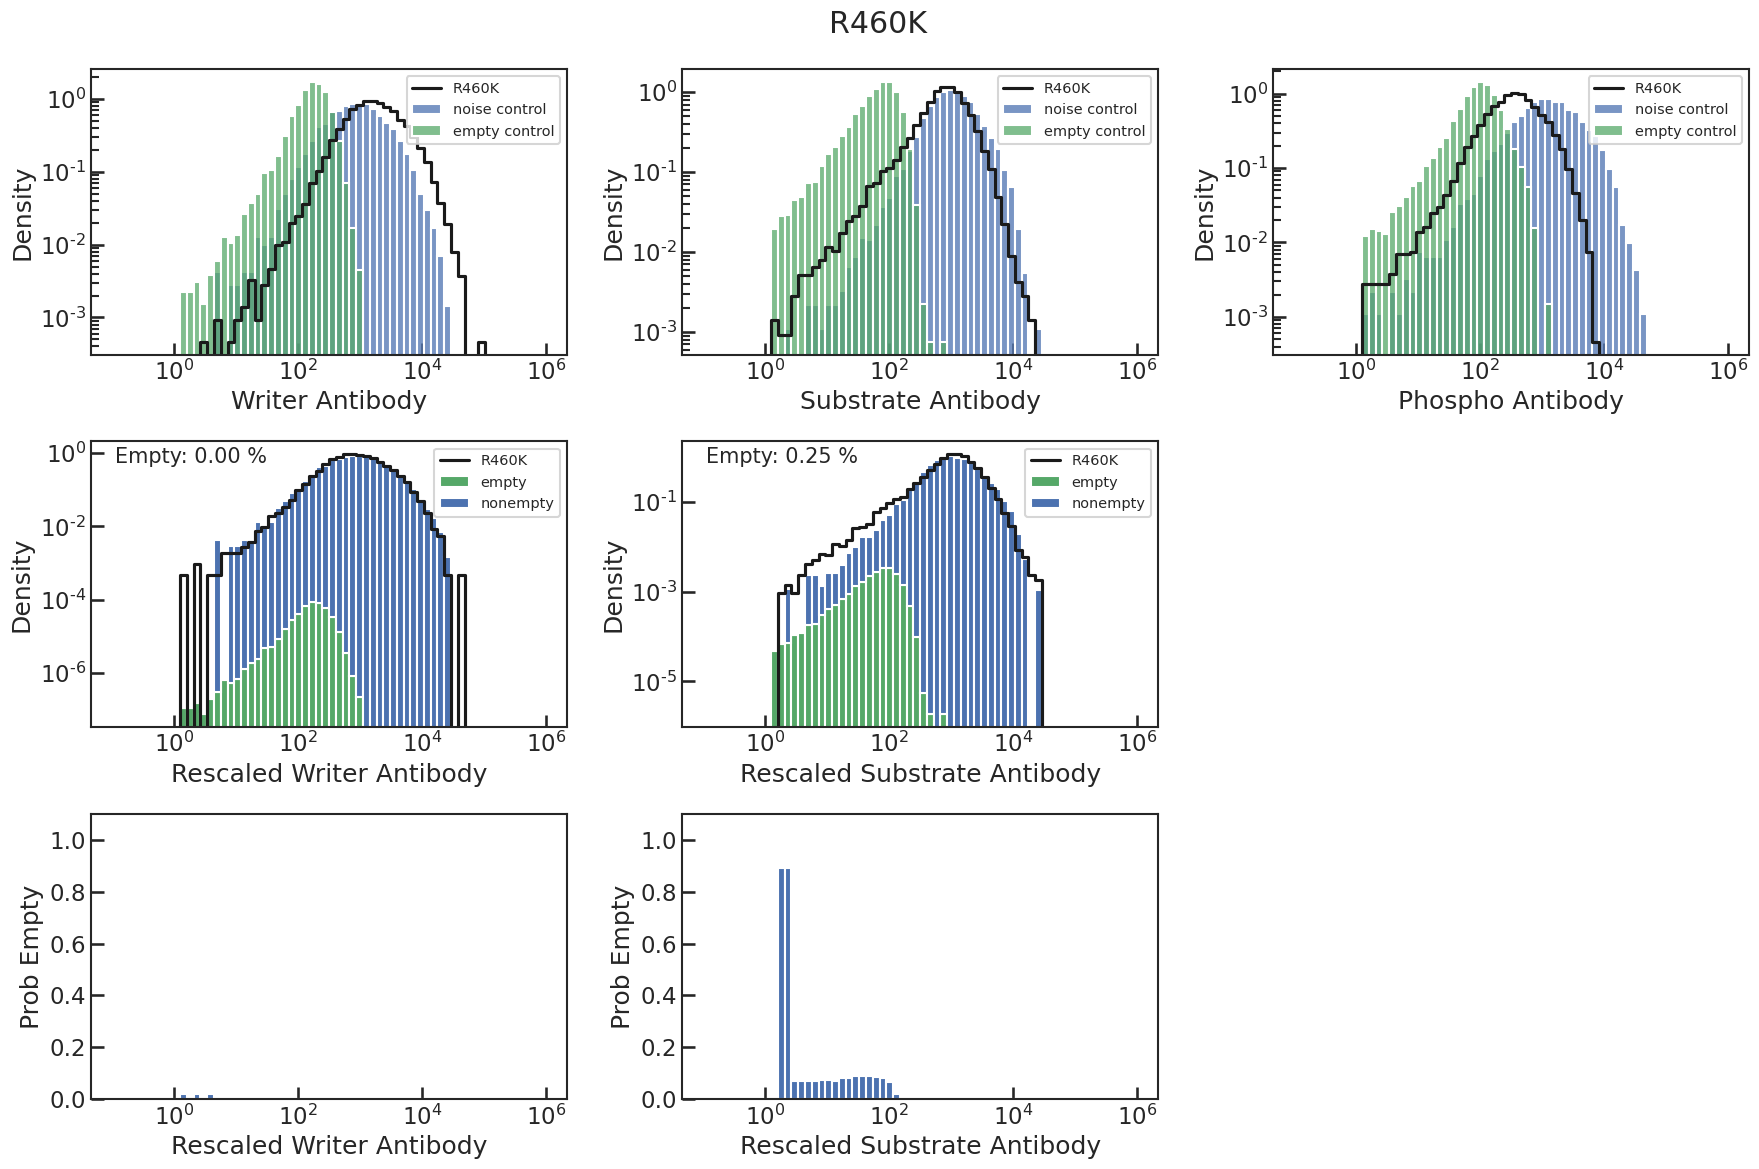

0.22335352672139785 [0.22510625 0.7046766 ] 0
0.17590139681178077 [0.22510625 0.32643269] 0
0.1654133819718566 [0.21053647 0.32643269] 0
0.15883776501458574 [0.01020641 0.13109813] 0
0.04357519798582965 [0.01020641 0.32670461] 0
0.04004027277565225 [0.0199694  0.32670461] 0
0.03893412082925696 [0.02302444 0.32670461] 0
0.03663155583312139 [0.00346857 0.30142179] 0
0.035874366754731074 [0.00222777 0.30142179] 0
0.03456467473873599 [8.15884136e-05 3.01421785e-01] 0
0.03456466798752257 [8.15884136e-05 3.01439047e-01] 0
0.03175891807779291 [8.15884136e-05 3.07365493e-01] 0
0.03173998094666439 [8.15884136e-05 3.07648741e-01] 0
0.03171285214545923 [3.68258906e-05 3.07648741e-01] 0
0.0315580499427328 [3.68258906e-05 3.07840153e-01] 0
0.03155022484021826 [3.68258906e-05 3.08025581e-01] 0
     fun: 0.03155022484021826
 message: ['Maximum number of iteration reached']
    nfev: 8002
    nhev: 0
     nit: 2000
    njev: 0
  status: 0
 success: True
       x: array([3.68258906e-05, 3.08025581e-01]

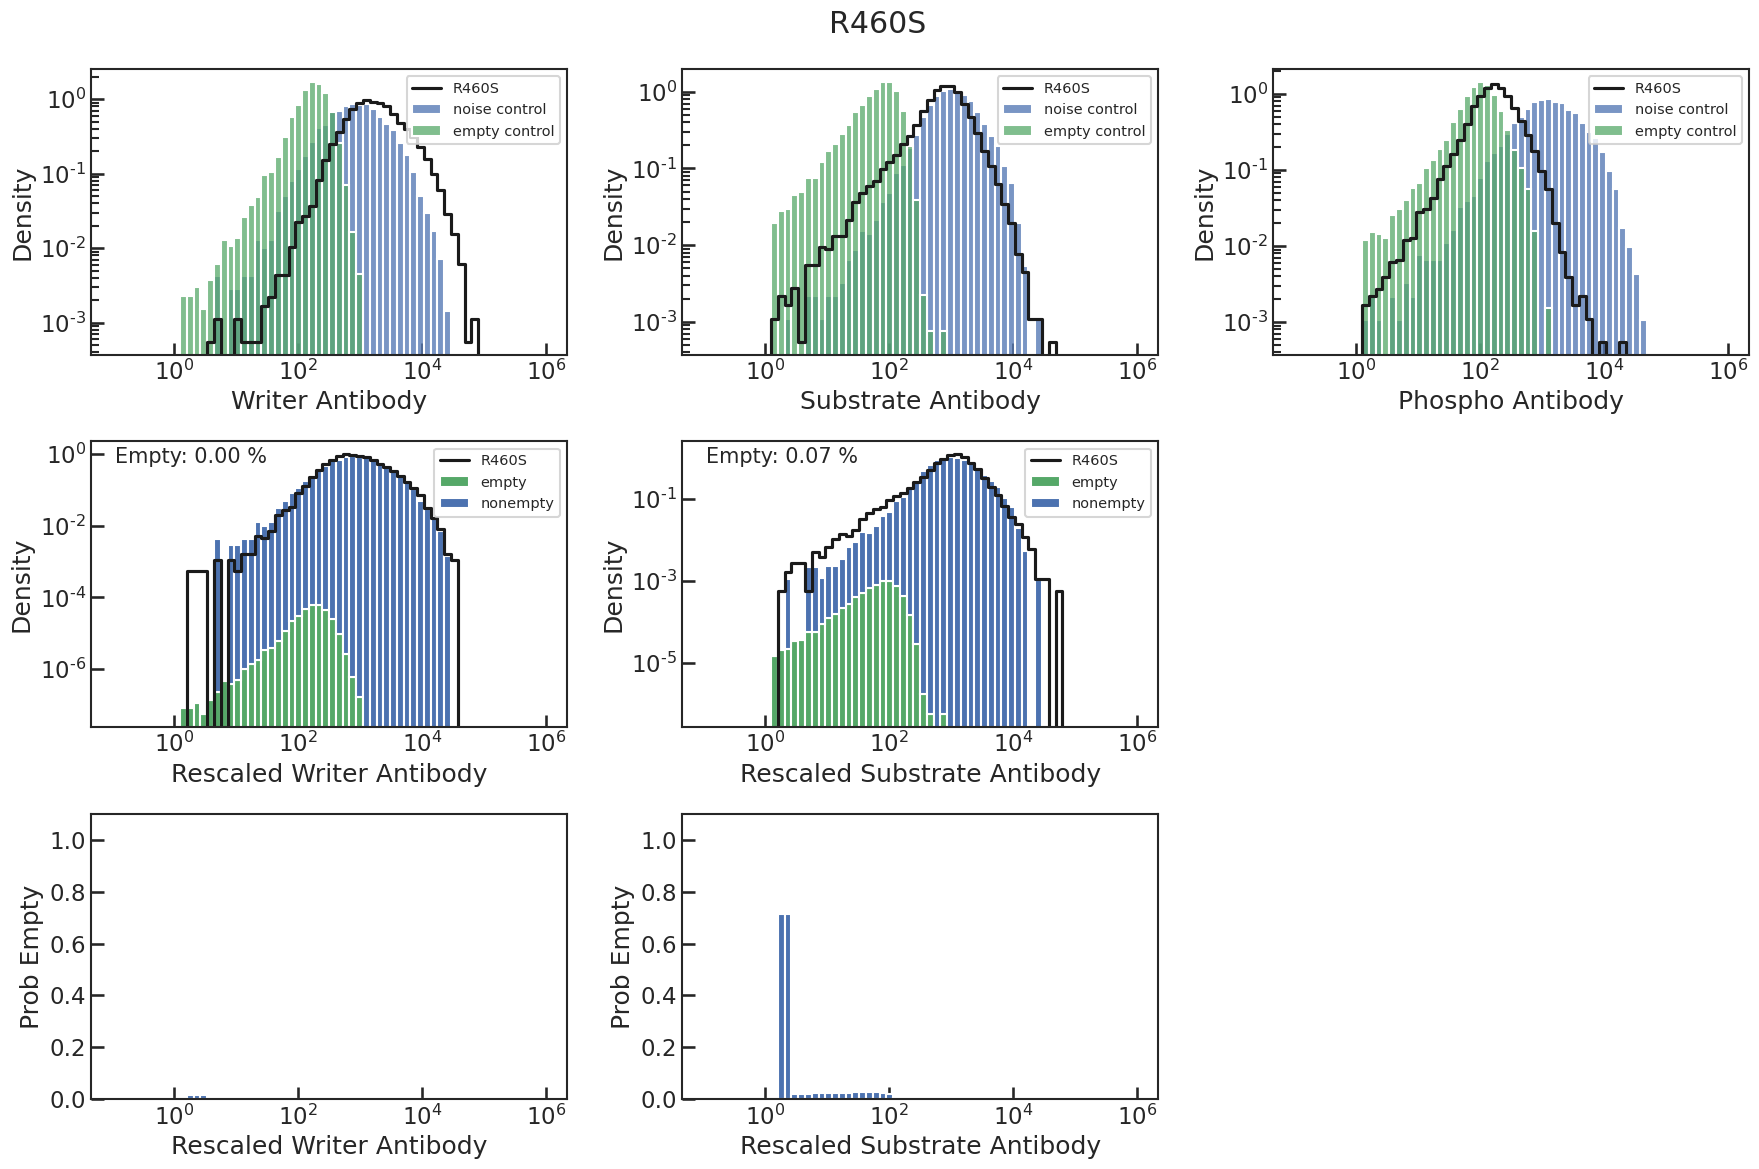

0.4364610356686202 [0.03007436 0.        ] 0
0.15813598336889512 [0.03007436 0.70500262] 0
0.10680111317291507 [0.15127639 0.70500262] 0
0.0843840876833416 [0.15127639 0.67326085] 0
0.05608717031970162 [0.18310693 0.63315052] 0
0.0549730264864412 [0.1567511  0.63315052] 0
0.0467101946412245 [0.13198482 0.60838424] 0
0.03547241544746771 [0.09024882 0.56779578] 0
0.03537254980933724 [0.09098611 0.56779578] 0
0.03337848979682623 [0.02240639 0.54177041] 0
0.032318937165357164 [0.06405961 0.54177041] 0
0.031123162309786734 [0.04330943 0.54177041] 0
0.03062496099506684 [0.0479269  0.54177041] 0
0.03054249473562587 [0.04869123 0.54177041] 0
0.030037544513876746 [0.05337125 0.54177041] 0
0.028558402281107398 [0.05337125 0.53760334] 0
0.02441355167736836 [0.00155734 0.50981001] 0
0.023042830601536224 [0.01422523 0.50981001] 0
0.022747122045707835 [0.0169581  0.50981001] 0
0.02267681434461155 [0.01760787 0.50981001] 0
0.0226603989848847 [0.01775958 0.50981001] 0
0.022418729043682917 [0.01999304 

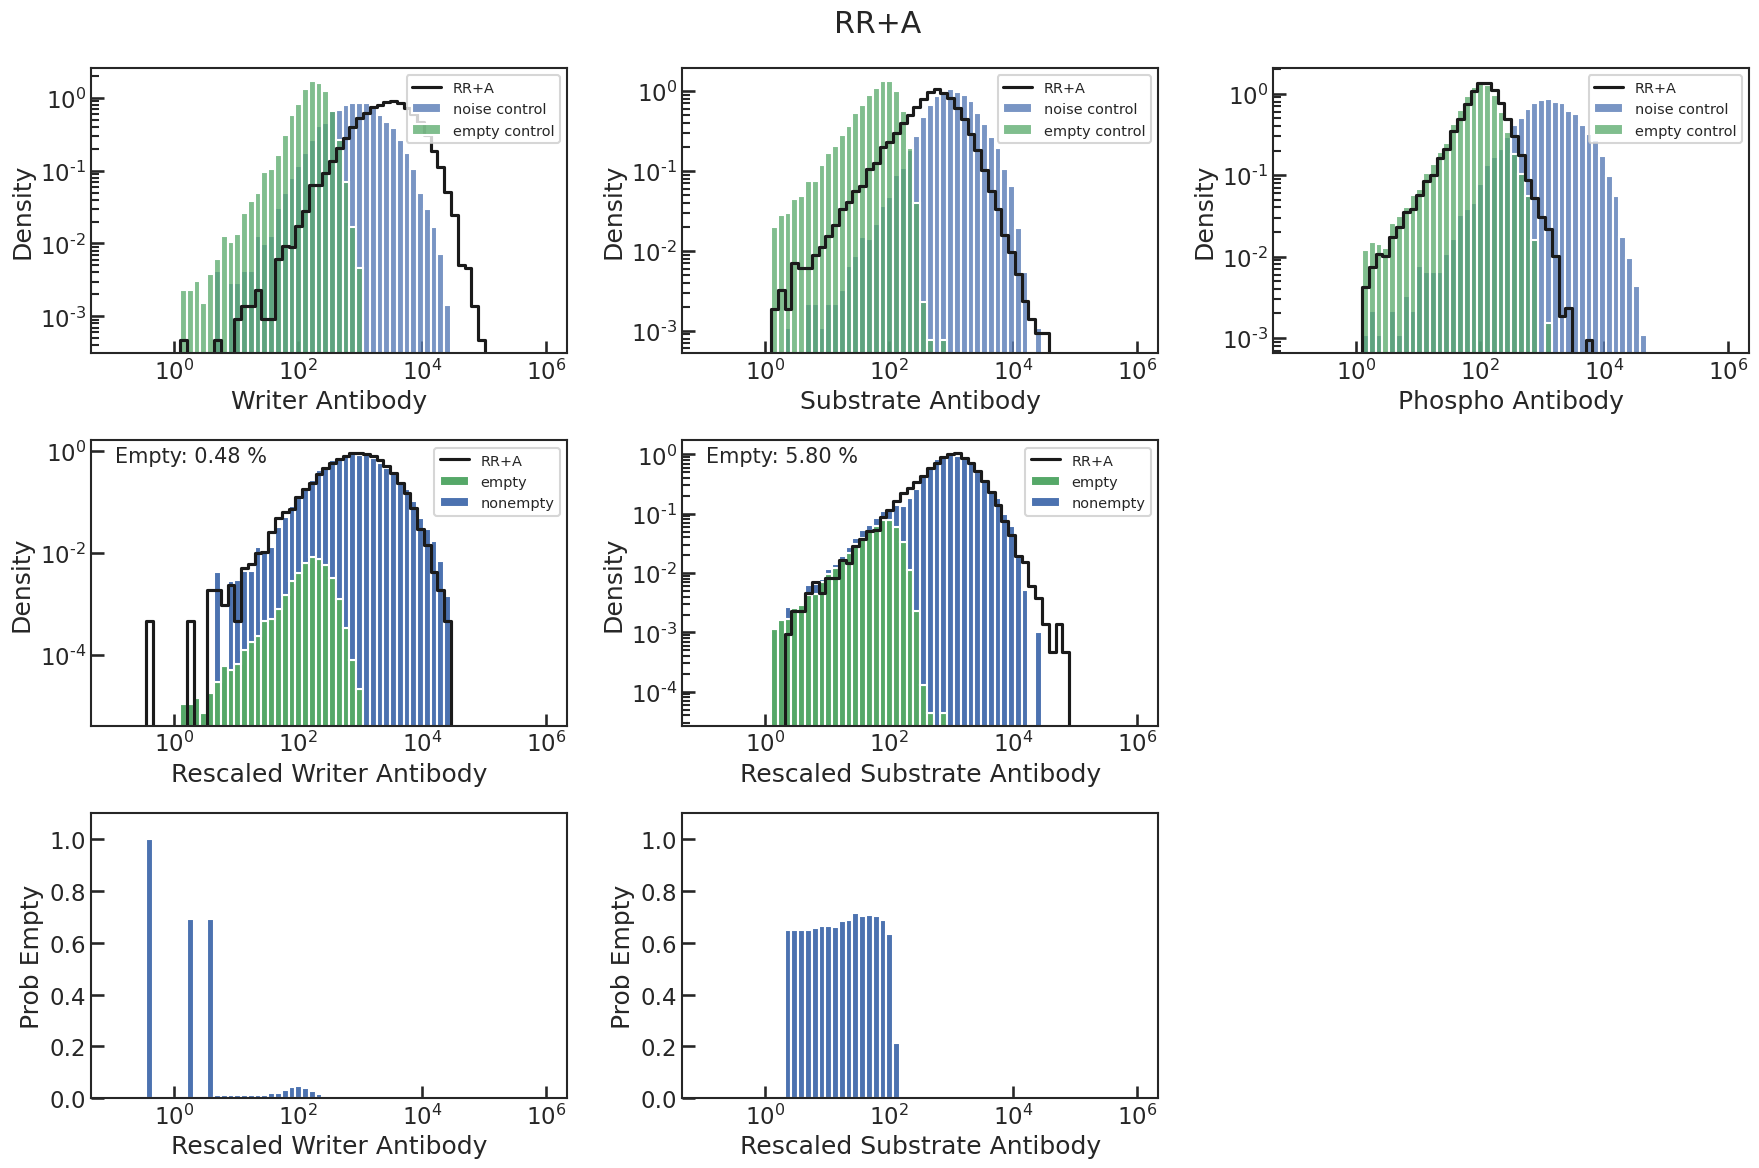

0.21344288348851492 [0.17896236 0.38457467] 0
0.14711853852714574 [0.06154972 0.38457467] 0
0.03854867461110861 [0.06154972 0.53148146] 0
0.03821605625181346 [0.03485726 0.53148146] 0
0.03627365355102563 [0.05283423 0.53148146] 0
0.03596185646213623 [0.05571991 0.53148146] 0
0.03550611439549778 [0.02266248 0.52166967] 0
0.03437109544381456 [0.03325818 0.52166967] 0
0.03416309638863568 [0.0351999  0.52166967] 0
0.033961582477970764 [0.03708109 0.52166967] 0
0.03364925599724378 [0.03999674 0.52166967] 0
0.03308635076414773 [0.01591432 0.49389817] 0
0.02599234888158719 [0.00204842 0.49389817] 0
0.025966837425429046 [0.00246992 0.49389817] 0
0.02587108225560153 [0.00405196 0.49389817] 0
0.025868272044441865 [0.00423395 0.49389817] 0
0.025862145892066035 [0.00422404 0.49389817] 0
0.02586214589206598 [0.00422404 0.49389388] 0
0.02581937256244271 [0.00277075 0.49331719] 0
0.02580405484362791 [0.00297604 0.49331719] 0
     fun: 0.02580405484362791
 message: ['Maximum number of iteration reache

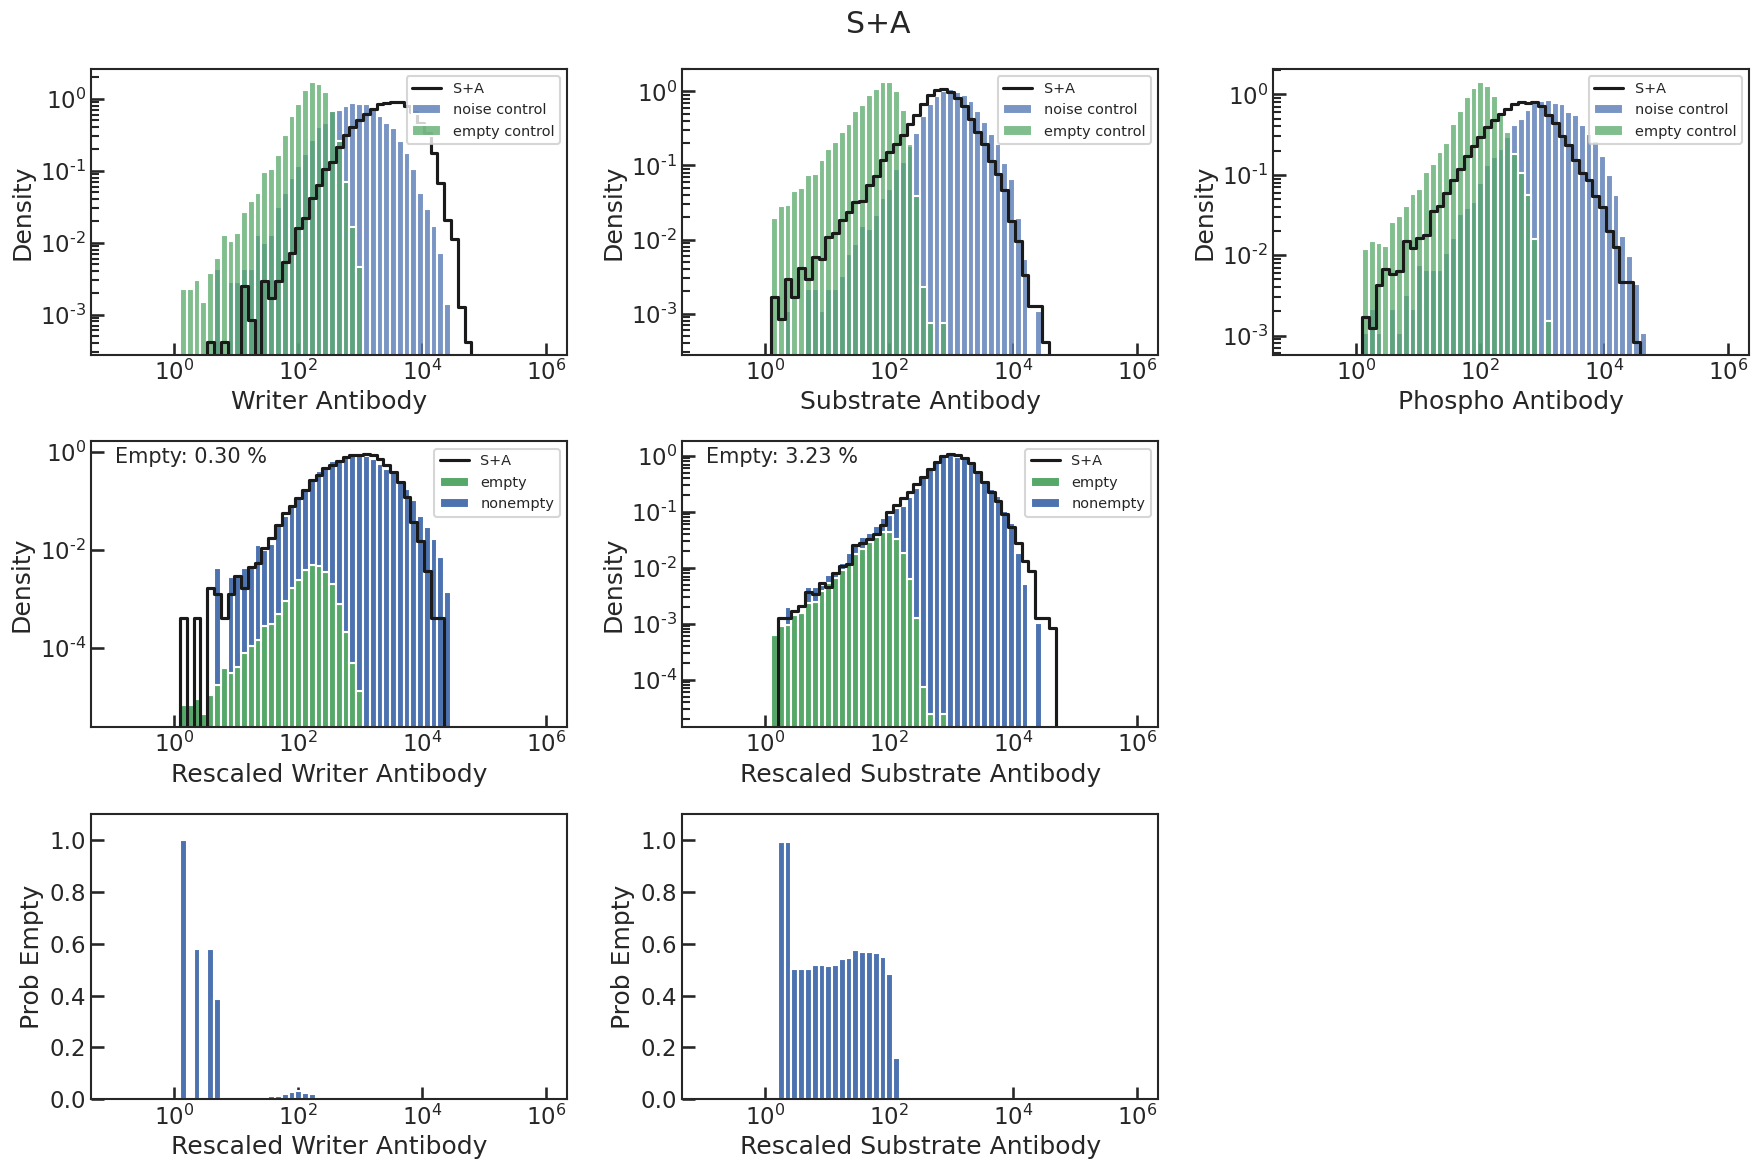

0.16811533740966986 [0.22060962 0.17060962] 0
0.16538737423784466 [0.12559643 0.4758729 ] 0
0.1081212984570542 [0.22770733 0.4758729 ] 0
0.05087141955927876 [0.22770733 0.35811152] 0
0.04477678827246412 [0.19001819 0.35811152] 0
0.04161138163124389 [0.19643819 0.35811152] 0
0.04063863247581101 [0.19857598 0.35811152] 0
0.037470651253016074 [0.20553819 0.35811152] 0
0.025917611764956217 [0.03839066 0.22481229] 0
0.025461340817540923 [0.03438044 0.22481229] 0
0.024587798999240795 [0.05002947 0.23254944] 0
0.023852527693533188 [0.05002947 0.23448598] 0
0.023848930893396014 [0.04888162 0.23448598] 0
0.022718327184804266 [0.06174805 0.24218877] 0
0.022270670115553504 [0.06307828 0.24218877] 0
0.02225066615906801 [0.06291132 0.24218877] 0
0.022250666159067456 [0.06291132 0.24216708] 0
0.022243731333682404 [0.06285344 0.24216708] 0
0.022231603283699164 [0.06265428 0.24216708] 0
0.022227501504038072 [0.06271798 0.24216708] 0
0.02222533242207181 [0.06269988 0.24216708] 0
0.022137770991214945 [0

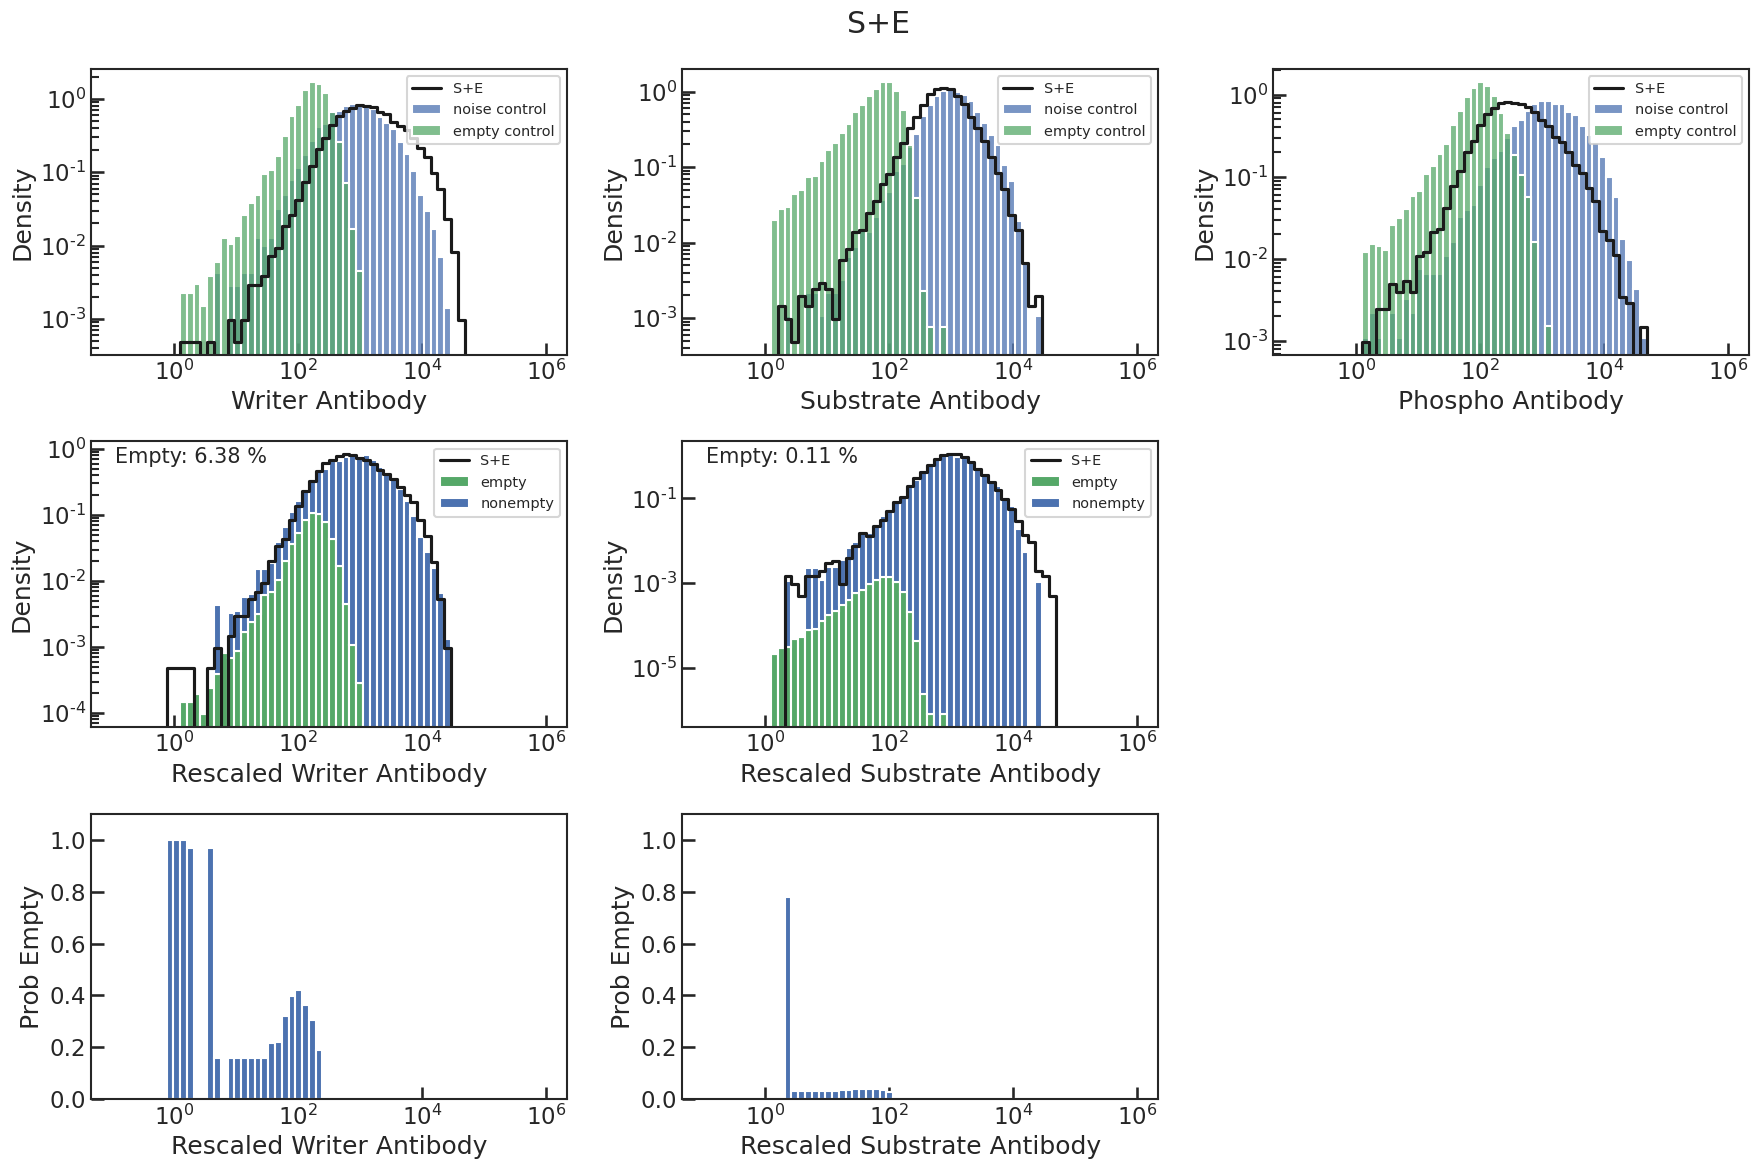

0.0952535206944527 [0.16610523 0.52386453] 0
0.07908932618487718 [0.09061286 0.44837216] 0
0.07076198451787075 [0.10553737 0.44837216] 0
0.04241754221718441 [0.15992327 0.44837216] 0
0.041993230866189335 [0.15405681 0.44422818] 0
0.040377308429497716 [0.15720459 0.44422818] 0
0.029098195359419654 [0.03372948 0.35111618] 0
0.026709213766049594 [0.05437736 0.35111618] 0
0.02525961119537451 [0.04100755 0.35111618] 0
0.023585820319946105 [0.04418111 0.35111618] 0
0.02281680438151923 [0.04576824 0.35111618] 0
0.022816804381519118 [0.04576824 0.35109907] 0
0.022816804381518896 [0.04576824 0.35093319] 0
0.022815290032568547 [0.04574438 0.35093319] 0
0.022792065764658087 [0.04537845 0.35093319] 0
0.02277240521175361 [0.04506868 0.35093319] 0
0.022770668702915775 [0.04504132 0.35093319] 0
0.022766847290296988 [0.04498111 0.35093319] 0
0.022766753306836307 [0.04497963 0.35093319] 0
0.022766753306836085 [0.04497963 0.35092749] 0
     fun: 0.022766753306836085
 message: ['Maximum number of iterati

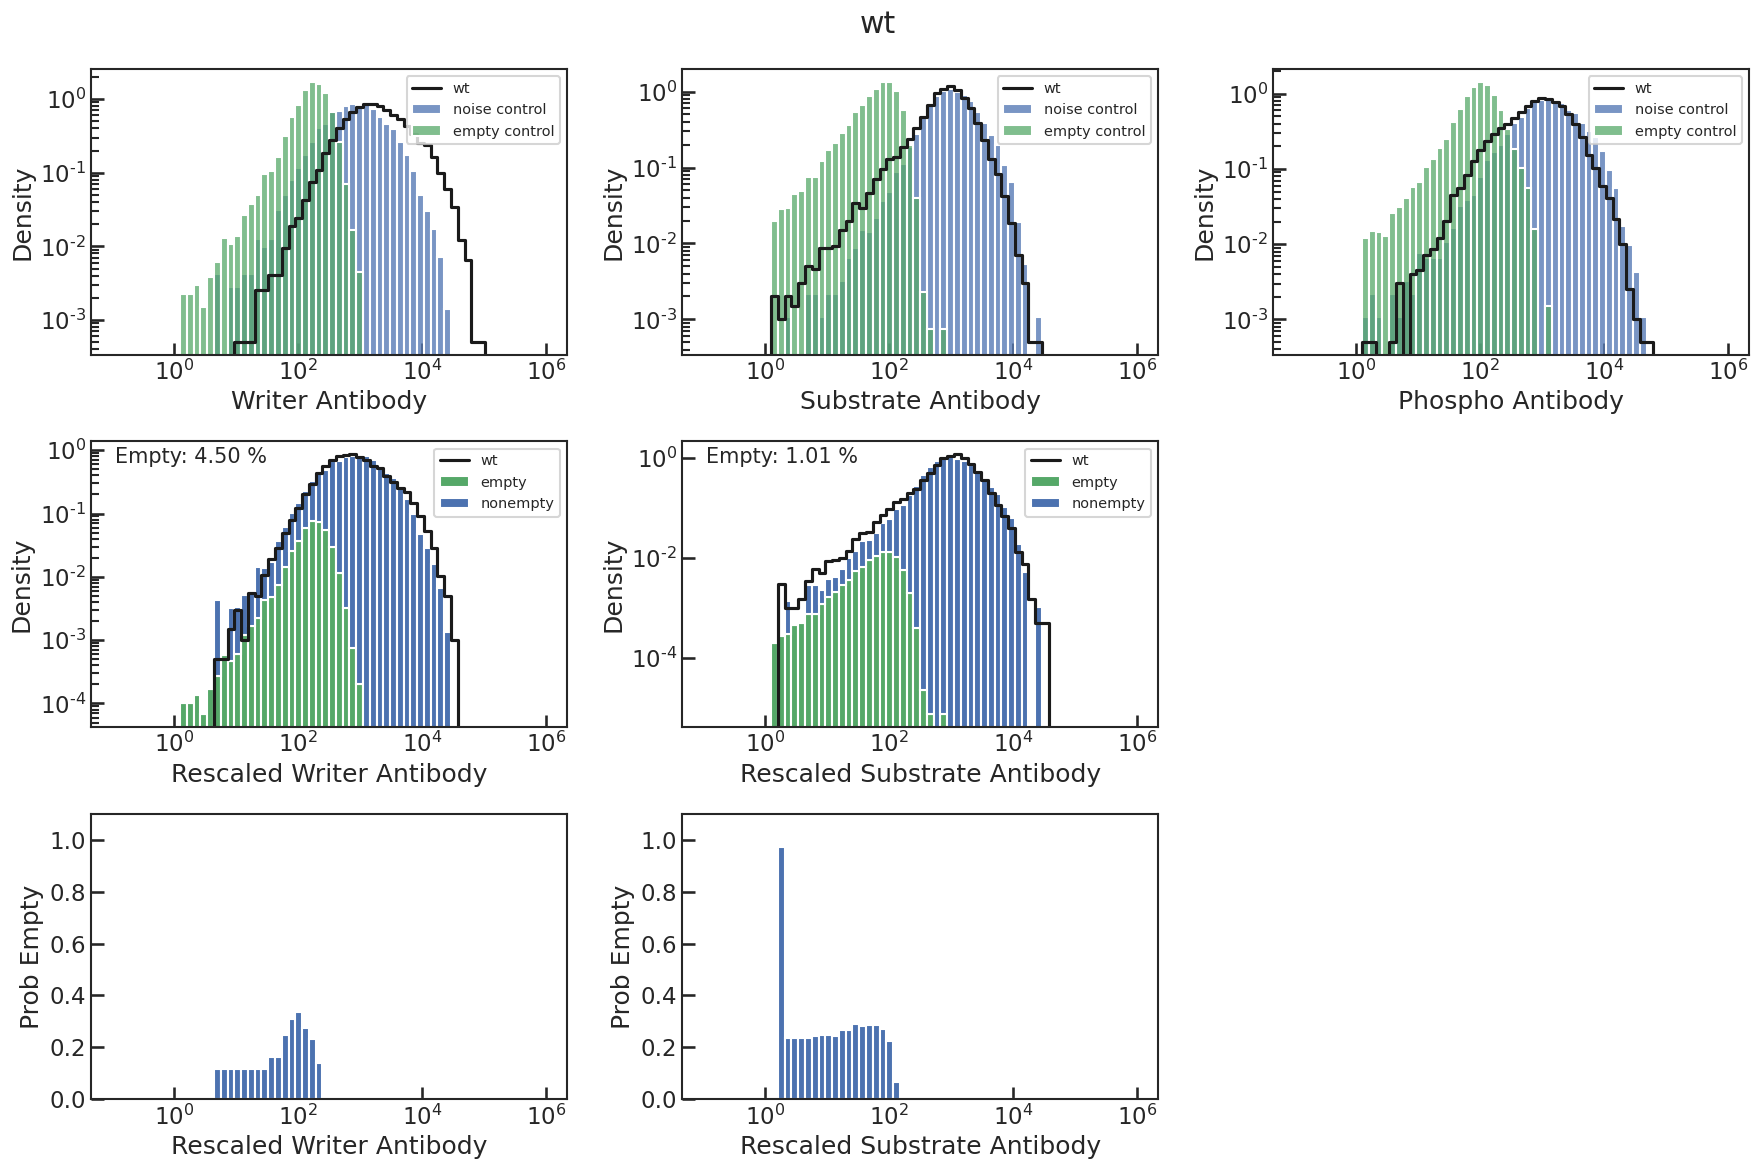

In [67]:
binrange = (-1, 6)

for i, (dataset, group) in enumerate(df.groupby("dataset")):

    
    fig = plt.figure(figsize=(18, 12))
    
    fig.suptitle(dataset)
    
    ax = fig.add_subplot(3, 3, 1)
    
    sns.histplot(group['WT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_writer_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
        
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ################################################################
    
    
    (writer_empty_frac, writer_anti_scale) = noise.calc_mixture(group['WT_anti_exp'], 
                                                                empty_writer_noise, writer_noise)

        
    df.loc[group.index, 'WT_anti_rescaled'] = group['WT_anti_exp'] / 10**writer_anti_scale
        
        
    ax = fig.add_subplot(3, 3, 4, sharex=ax)
            
    
    
    sns.histplot(df.loc[group.index, 'WT_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(writer_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_writer_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*writer_empty_frac, nonempty_hist/nonempty_norm*(1-writer_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*writer_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    
    ################################################################
    
    df.loc[group.index, 'WT_prob_empty'] = noise.calc_prob_empty(df.loc[group.index, 'WT_anti_rescaled'], 
                                                                 writer_empty_frac, 
                                                                 empty_writer_noise, writer_noise)
    
    ax = fig.add_subplot(3, 3, 7, sharex=ax)
    
    df_tmp = group.copy()
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'WT_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'WT_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Writer Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    
    
    ax = fig.add_subplot(3, 3, 2)
        
    sns.histplot(group['ST_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_substrate_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
    
    
    ################################################################
    
    (substrate_empty_frac, substrate_anti_scale) = noise.calc_mixture(group['ST_anti_exp'], 
                                                                empty_substrate_noise, substrate_noise)

        
    ax = fig.add_subplot(3, 3, 5, sharex=ax)
            
    df.loc[group.index, 'ST_anti_rescaled'] = group['ST_anti_exp'] / 10**substrate_anti_scale
    
    sns.histplot(df.loc[group.index, 'ST_anti_rescaled'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    
    
    nonempty_hist, edges = np.histogram(np.log10(substrate_noise.get_anti()), range=binrange, bins=64)
    nonempty_norm = np.sum(nonempty_hist*(edges[1:]-edges[0:len(edges)-1]))
    
    empty_hist, edges = np.histogram(np.log10(empty_substrate_noise.get_anti()), range=binrange, bins=64)
    empty_norm = np.sum(empty_hist*(edges[1:]-edges[0:len(edges)-1]))

    ax.hist([10**edges[:-1], 10**edges[:-1]], 10**edges, 
            weights=[empty_hist/empty_norm*substrate_empty_frac, nonempty_hist/nonempty_norm*(1-substrate_empty_frac)], 
            histtype='barstacked', color=['g', 'b'], label=['empty', 'nonempty'])
    
        
    ax.set_xlabel("Rescaled Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
    
    ax.set_yscale('log')
      
    ax.text(0.05, 0.98, "Empty: {0:.2f} %".format(100*substrate_empty_frac), transform=ax.transAxes,
           va='top', ha='left', fontsize='small')
    
    
    ################################################################
    
    df.loc[group.index, 'ST_prob_empty'] = noise.calc_prob_empty(df.loc[group.index, 'ST_anti_rescaled'], 
                                                                 substrate_empty_frac, 
                                                                 empty_substrate_noise, substrate_noise)
    
    ax = fig.add_subplot(3, 3, 8, sharex=ax)
    
    df_tmp = group.copy()
    df_tmp['bin'] = pd.cut(df.loc[df_tmp.index, 'ST_anti_rescaled'], 10**edges, labels=False)
    df_tmp['prob_empty'] = df.loc[df_tmp.index, 'ST_prob_empty']    
    
    hist_corr = df_tmp.groupby(['bin'])['prob_empty'].mean().to_frame("mean")
    
    hist_corr =  hist_corr.reindex(pd.Index(np.arange(len(edges)-1), name='bin', fill_value=np.nan))['mean'].values
    hist_corr = np.nan_to_num(hist_corr)

    ax.hist(10**edges[:-1], 10**edges, weights=hist_corr, histtype='bar', color='b')
    
    ax.set_ylim(0, 1.1)
    
    ax.set_xlabel("Rescaled Substrate Antibody")
    ax.set_ylabel("Prob Empty")
    
    
    ################################################################
    
    ax = fig.add_subplot(3, 3, 3)
    
    sns.histplot(group['SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()


In [68]:

zero = 0.0

for dataset, group in df.groupby("dataset"): 
    
    # convert antibody measurements to GFP measurements
    GFP_infer, anti_bin, GFP_bin = writer_noise.anti_to_GFP(df.loc[group.index, 'WT_anti_rescaled'])
    df.loc[group.index, 'WT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'WT_anti_bin'] = anti_bin
#     df.loc[group.index, 'WT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'WT_conc_infer'] = np.maximum(df.loc[group.index, 'WT_GFP_infer'] - np.median(empty_writer_noise.get_GFP()), zero)

    GFP_infer, anti_bin, GFP_bin = substrate_noise.anti_to_GFP(df.loc[group.index, 'ST_anti_rescaled'])
    df.loc[group.index, 'ST_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'ST_anti_bin'] = anti_bin
#     df.loc[group.index, 'ST_GFP_bin'] = GFP_bin
    df.loc[group.index, 'ST_conc_infer'] = np.maximum(df.loc[group.index, 'ST_GFP_infer'] - np.median(empty_substrate_noise.get_GFP()), zero)

    
    GFP_infer, anti_bin, GFP_bin = combined_phospho_noise.anti_to_GFP(df.loc[group.index, 'SpT_anti_exp'])
    df.loc[group.index, 'SpT_GFP_infer'] = GFP_infer
#     df.loc[group.index, 'SpT_anti_bin'] = anti_bin
#     df.loc[group.index, 'SpT_GFP_bin'] = GFP_bin
    df.loc[group.index, 'SpT_conc_infer'] = np.maximum(df.loc[group.index, 'SpT_GFP_infer'] - np.median(empty_phospho_noise.get_GFP()), zero)

    df.loc[group.index, 'Sp_frac_GFP_infer'] = df.loc[group.index, 'SpT_GFP_infer'] / df.loc[group.index, 'ST_GFP_infer']
    df.loc[group.index, 'Sp_frac_conc_infer'] = df.loc[group.index, 'SpT_conc_infer'] / df.loc[group.index, 'ST_conc_infer']
    
    
    df.loc[group.index, 'total_prob_empty'] = 1.0 - (1-df.loc[group.index, 'ST_prob_empty'])*(1-df.loc[group.index, 'WT_prob_empty'])
    
    
print(len(df))
print(len(df.dropna()))


183583
183583


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


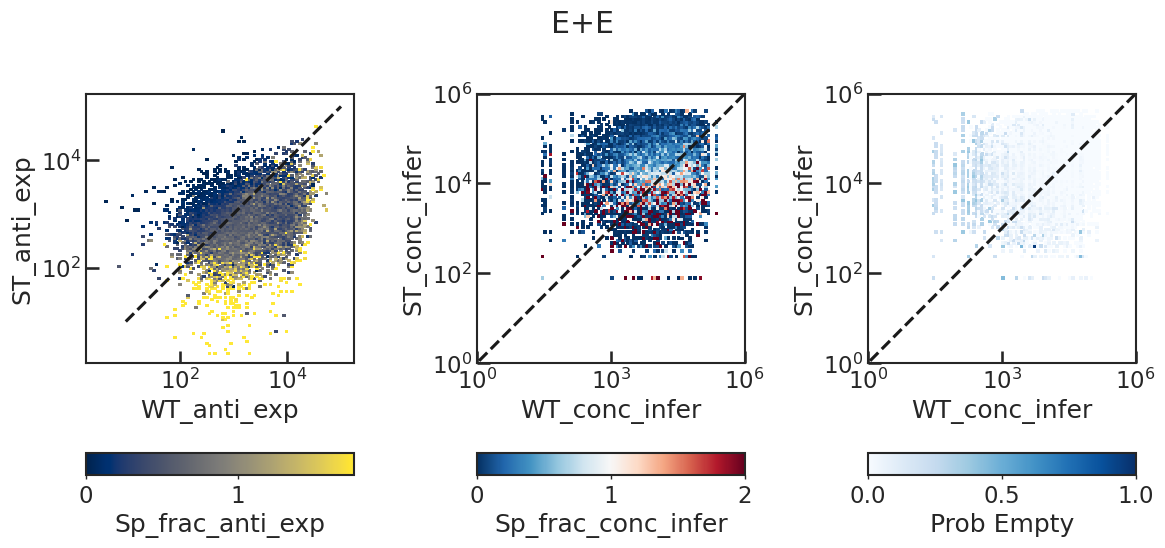

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


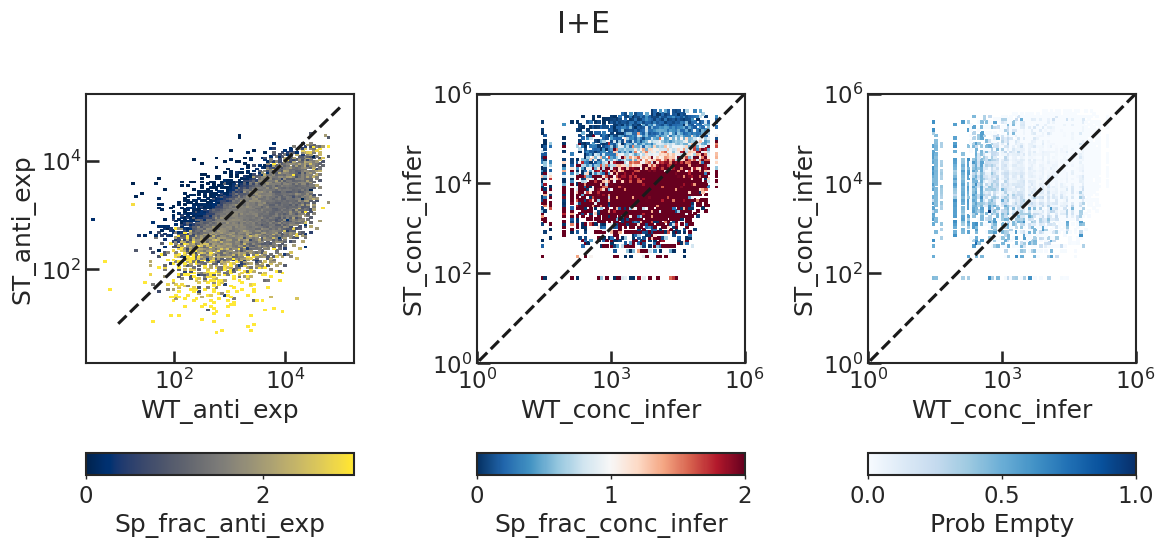

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


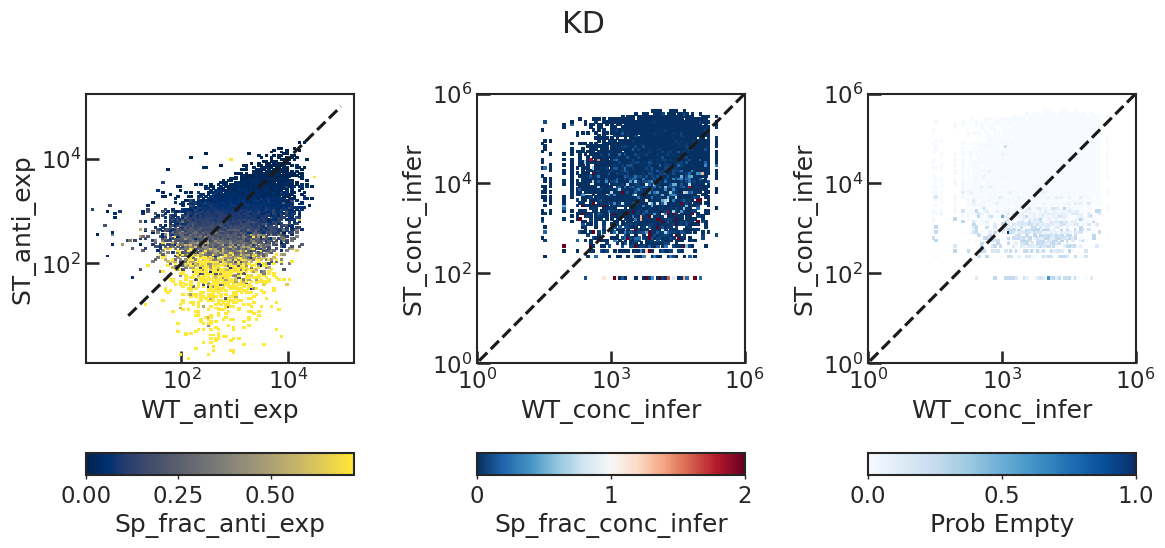

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


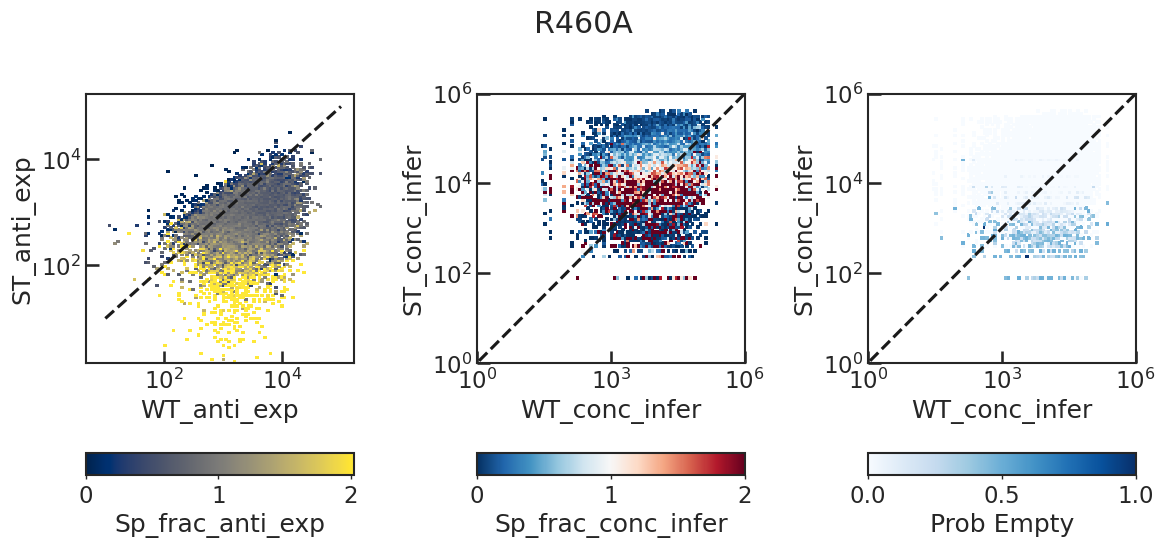

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


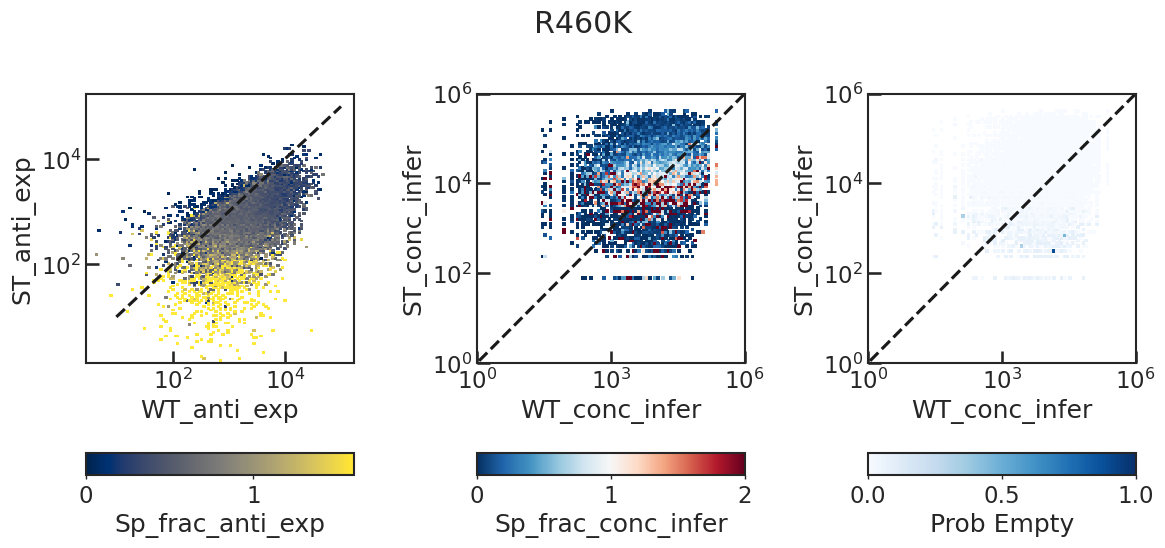

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


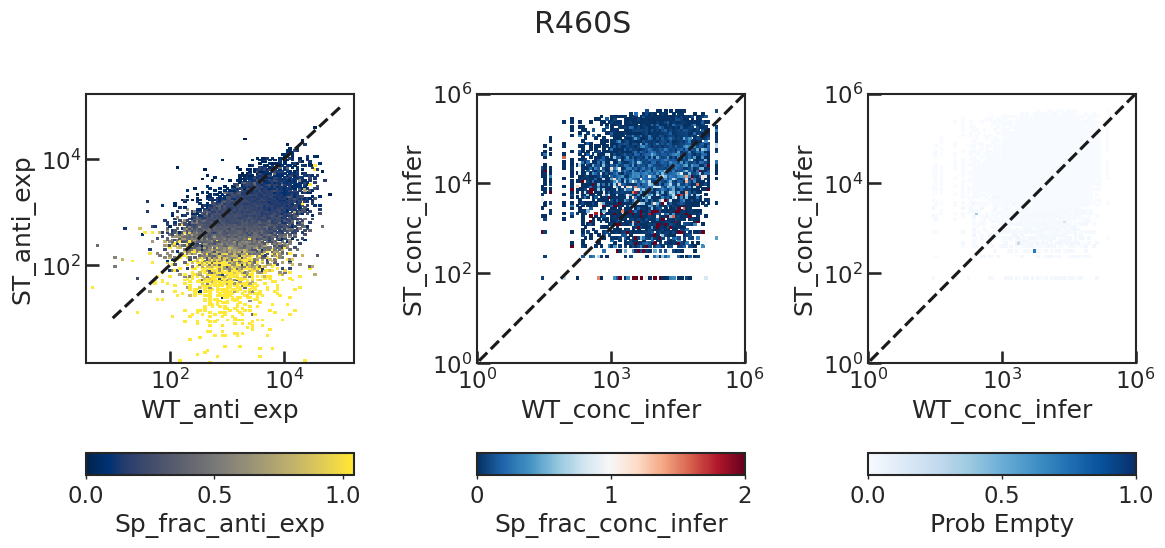

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


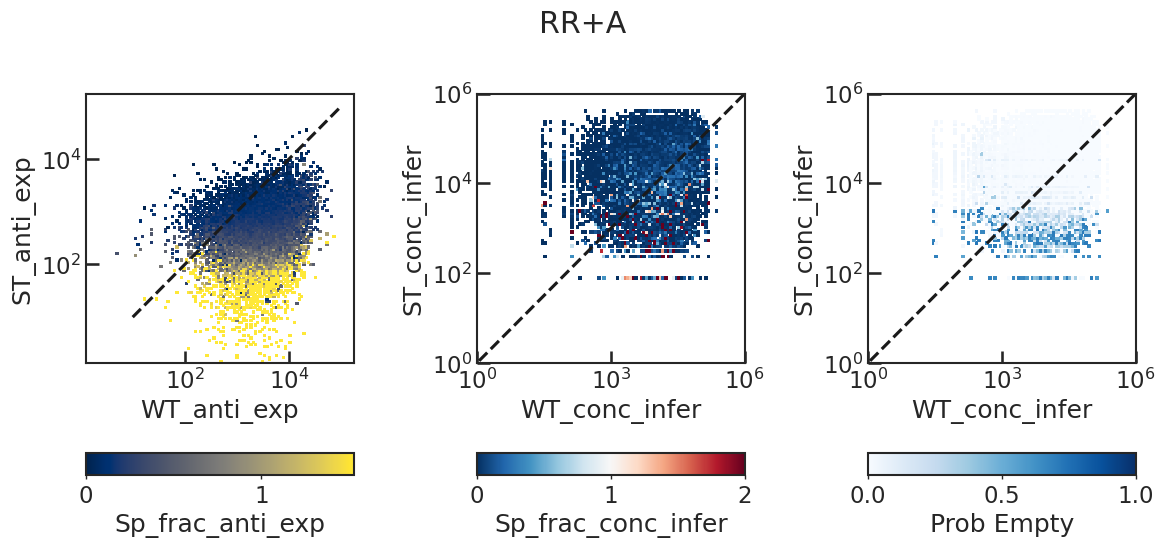

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


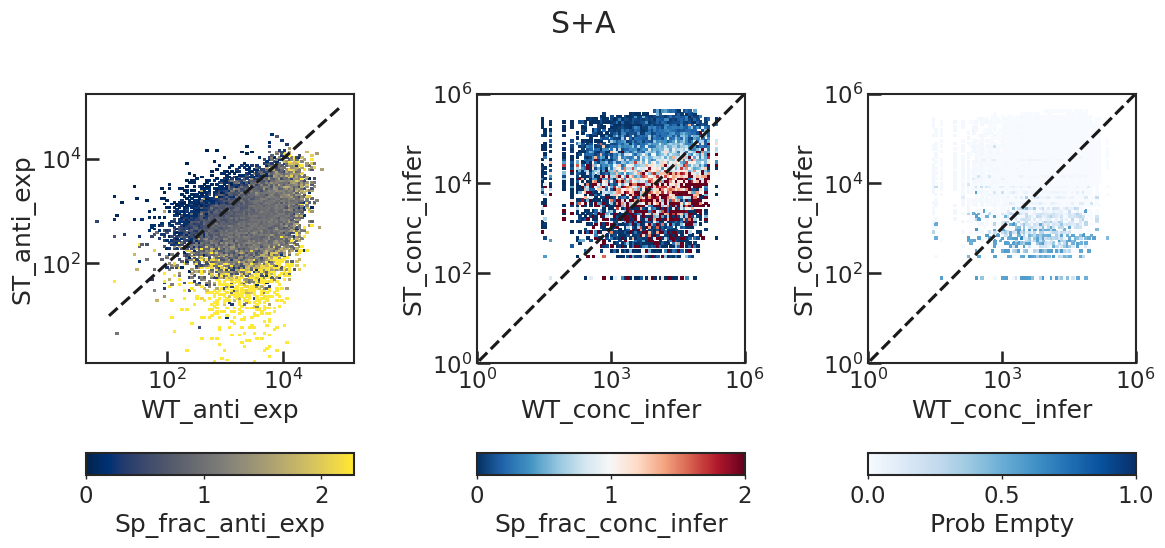

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


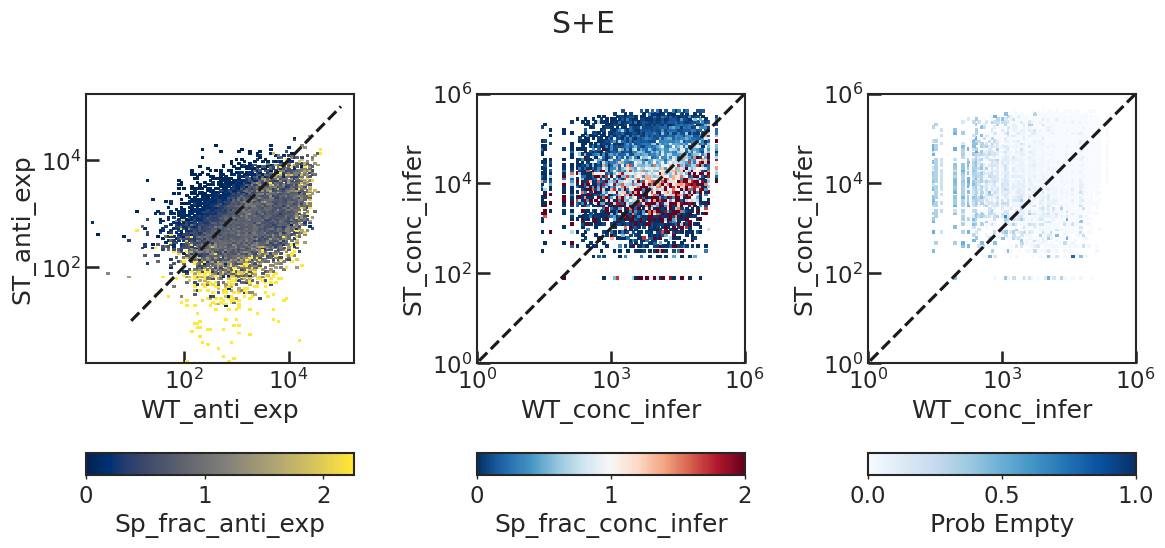

/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


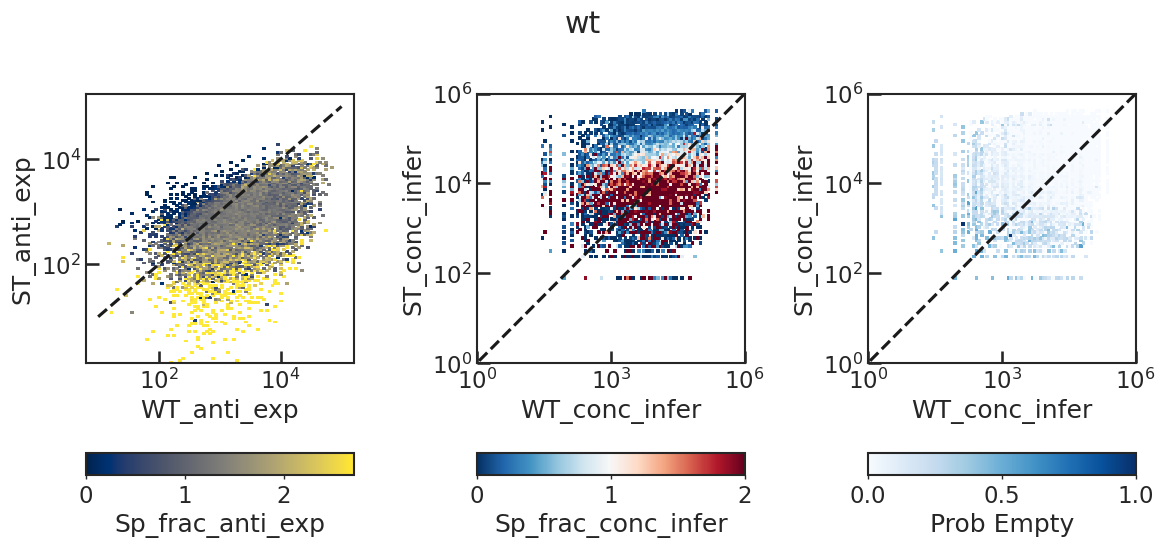

In [69]:



for i, (dataset, group) in enumerate(df.groupby("dataset")):
    
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
    
    ax = axes[0]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap1=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap1, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    ax = axes[1]
    
    df_tmp = group.copy().dropna()
        
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins=100, range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins=100, range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

#     xedges = writer_bins
#     yedges = substrate_bins

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap2=plt.cm.RdBu_r
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap2, norm=norm2, rasterized=True)
    
    t = np.linspace(1e-1, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    
    
    ax = axes[2]
    
 
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['total_prob_empty'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap3=plt.cm.Blues
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e-1, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    

    fig.suptitle(dataset)
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc_infer")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Prob Empty")
    
    

    plt.show()
    

In [74]:
def solve(df_data, df_info, param_dict, x0, bounds, verbose=False):
    
    df_copy = df.dropna().copy()
    
    if verbose:
        start = time.time()

#     loss_dict = {}
    def func(x):
                        
        loss = 0.0
        
        
        
        for index, row in df_info.iterrows():
            dataset = row['dataset']
                        
            model_params = 10**np.array(x)[param_dict[dataset]]
                
            df_data = df_copy.query("dataset==@dataset")
            
#            
            if row['model'] == 'push':
                            
            
                df_copy.loc[df_data.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_data[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
            
                       
            df_copy.loc[df_data.index, 'SpT_GFP_predict'] = df_copy.loc[df_data.index, 'SpT_conc_predict'] + np.median(empty_phospho_noise.get_GFP())
            
#             loss_dict[dataset] = np.mean((np.log10(df_copy.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df_copy.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            prob_empty = df_copy.loc[df_data.index, 'total_prob_empty']  
            
            loss += np.mean((1-prob_empty)*(np.log10(df_copy.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df_copy.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            
        # add small tether regularization to initial conditions
        loss += 1e-6*np.sum((x-np.array(x0))**2)
                                           
        return loss




    print("Initial Loss:", func(x0))

    def callback(x):
        print(func(x), 1e-6*np.sum((x-np.array(x0))**2), x)
#         print(loss_dict)

#     res = opt.minimize(func, x0, method='L-BFGS-B', 
#                        jac='2-point', bounds=bounds, 
#                        options={'iprint':101, 'eps': 1e-6, 
#                                 'gtol': 1e-6, 'ftol':1e-6},
#                       callback=callback)
    res = opt.minimize(func, x0, method='BFGS', 
                       jac='2-point', 
                       options={'eps': 1e-6, 'gtol': 1e-4, 'disp': True},
                      callback=callback)
    

    print("Final Loss:", res.fun, func(res.x))

    end = time.time()

    print("Time Elapsed", end-start, "seconds")

    print(res)
        
    
    return res

In [75]:
zippers = {}
kinases = {}

param_dict = {}

param_labels = [r"$\log_{10}(v_{bg}^p)$"]
x0 = [-2.0]
bounds = [(None, None)]


param_index = 1
for index, row in df_info.iterrows():
    
    dataset = row['dataset']
    zipper = row['zipper']
    kinase = row['kinase']
    model = row['model']
    
    if model == 'push':

        # assign background phospho rate
        param_dict[dataset] = [0]

        # assign kinase phospho rate
        if kinase not in kinases:
            kinases[kinase] = param_index
            param_labels.append(kinase + ": " + r"$\log_{10}(v_{WS}^p)$")
            x0.append(0.0)
            bounds.append((None, None))
            param_index += 1
            
        param_dict[dataset].append(kinases[kinase])

        # assign zipper binding affinity
        if zipper not in zippers:
            zippers[zipper] = param_index
            param_labels.append(zipper + ": " + r"$\log_{10}(\alpha_{WS})$")
            x0.append(4.0)
            bounds.append((None, None))
            param_index += 1

        param_dict[dataset].append(zippers[zipper])

    
print(param_labels)
print(param_dict)

print(x0)
print(bounds)

res = solve(df, df_info, param_dict, x0, bounds, verbose=True)


['$\\log_{10}(v_{bg}^p)$', 'wt: $\\log_{10}(v_{WS}^p)$', 'E+E: $\\log_{10}(\\alpha_{WS})$', 'I+E: $\\log_{10}(\\alpha_{WS})$', 'RR+A: $\\log_{10}(\\alpha_{WS})$', 'S+A: $\\log_{10}(\\alpha_{WS})$', 'S+E: $\\log_{10}(\\alpha_{WS})$', 'generic: $\\log_{10}(\\alpha_{WS})$', 'KD: $\\log_{10}(v_{WS}^p)$', 'R460A: $\\log_{10}(v_{WS}^p)$', 'R460K: $\\log_{10}(v_{WS}^p)$', 'R460S: $\\log_{10}(v_{WS}^p)$']
{'E+E': [0, 1, 2], 'I+E': [0, 1, 3], 'RR+A': [0, 1, 4], 'S+A': [0, 1, 5], 'S+E': [0, 1, 6], 'wt': [0, 1, 7], 'KD': [0, 8, 7], 'R460A': [0, 9, 7], 'R460K': [0, 10, 7], 'R460S': [0, 11, 7]}
[-2.0, 0.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Initial Loss: 15.428989734439707
13.126491386593807 1.0201000000000008e-06 [-2.10549864 -0.55468866  4.05694793  3.9251993   4.14105443  4.00802513
  4.03071464  4.2583709  -0.6251

[5.62441115e-04 3.66375235e+00 9.50229131e+05]


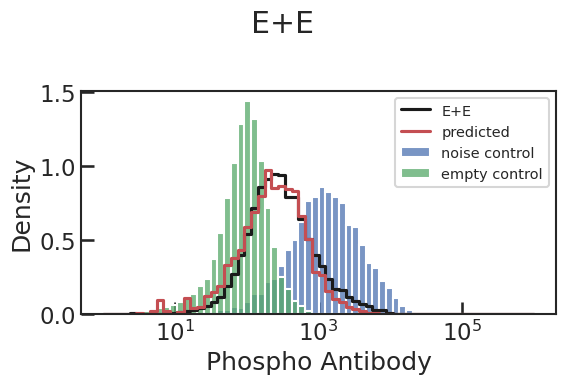

[5.62441115e-04 3.66375235e+00 2.91156961e-01]


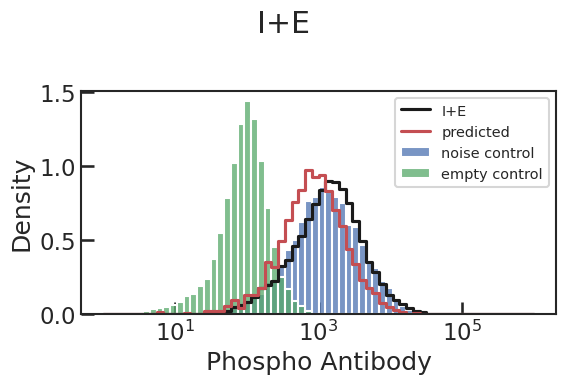

[5.62441115e-04 6.91786797e-07 1.74136511e+03]


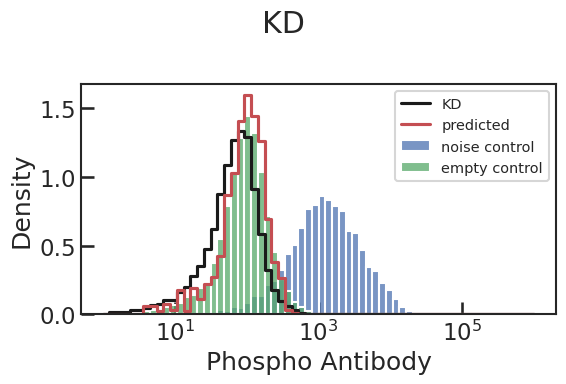

[5.62441115e-04 1.32380983e+00 1.74136511e+03]


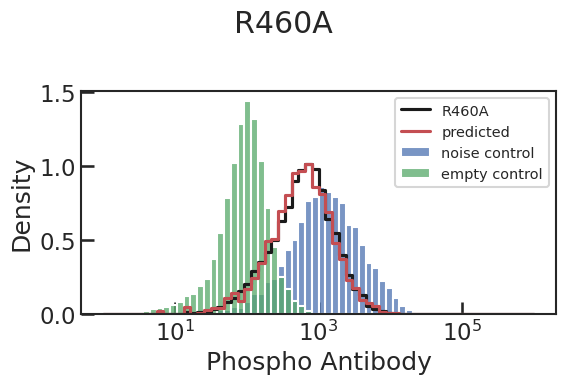

[5.62441115e-04 2.54125671e-01 1.74136511e+03]


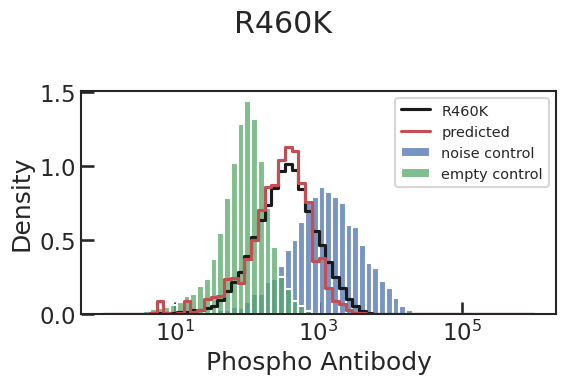

[5.62441115e-04 1.95785275e-02 1.74136511e+03]


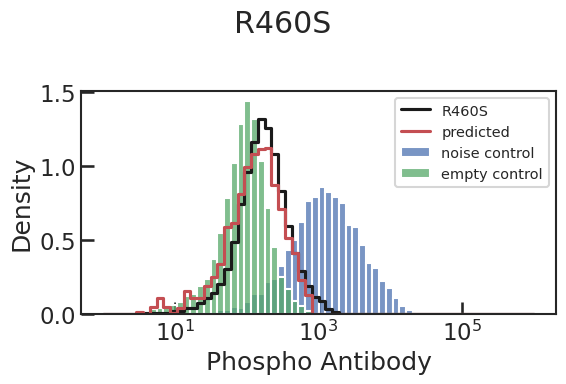

[5.62441115e-04 3.66375235e+00 6.73635460e+07]


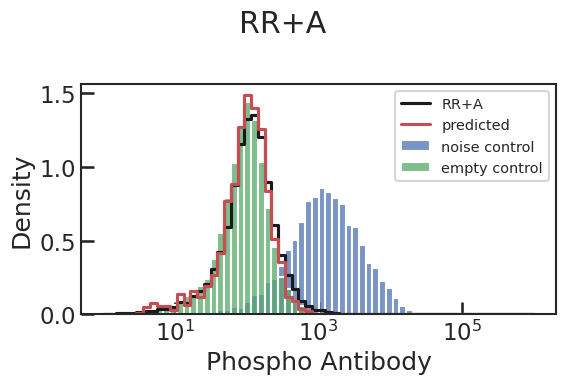

[5.62441115e-04 3.66375235e+00 1.33422146e+05]


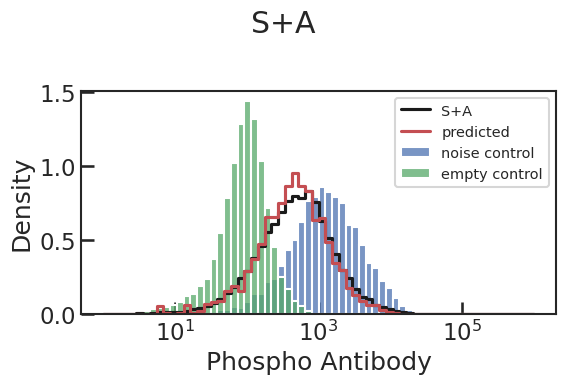

[5.62441115e-04 3.66375235e+00 3.47758711e+05]


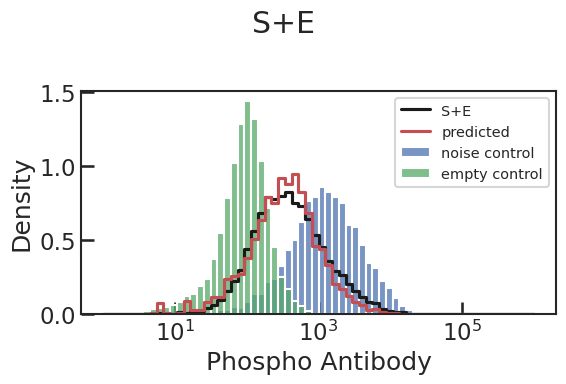

[5.62441115e-04 3.66375235e+00 1.74136511e+03]


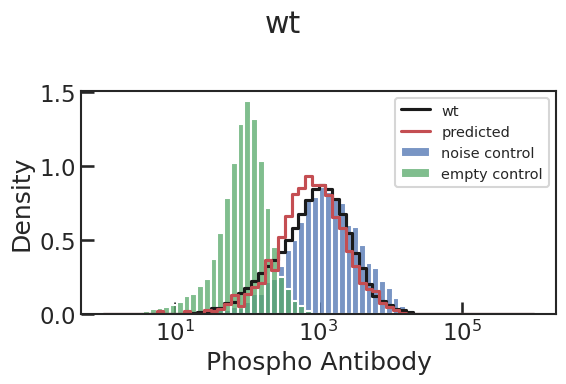

In [79]:
binrange = (0, 6)

for i, (dataset, group) in enumerate(df.groupby("dataset")):

    
    model_params = 10**res.x[param_dict[dataset]]
    
    print(model_params)
    
    df.loc[group.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(group[['WT_conc_infer', 'ST_conc_infer']].values, model_params)[:, 0]
    df.loc[group.index, 'SpT_GFP_predict'] = df.loc[group.index, 'SpT_conc_predict'] + np.median(empty_phospho_noise.get_GFP())
    
    anti, GFP_bins, anti_bins = inverse_phospho_noise.GFP_to_anti(df.loc[group.index, 'SpT_GFP_predict'])
    
    df.loc[group.index, 'SpT_anti_predict'] = anti
    
    df.loc[group.index, 'Sp_frac_conc_predict'] = df.loc[group.index, 'SpT_conc_predict'] / group['ST_conc_infer']
    
    
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    
    fig.suptitle(dataset)

    
    ax = axes
    
    sns.histplot(df.loc[group.index, 'SpT_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=dataset, element='step', fill=False, color='k', stat='density')
    sns.histplot(df.loc[group.index, 'SpT_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='noise control', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')
        
    plt.tight_layout()
    
    plt.show()
    

[5.62441115e-04 3.66375235e+00 9.50229131e+05]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


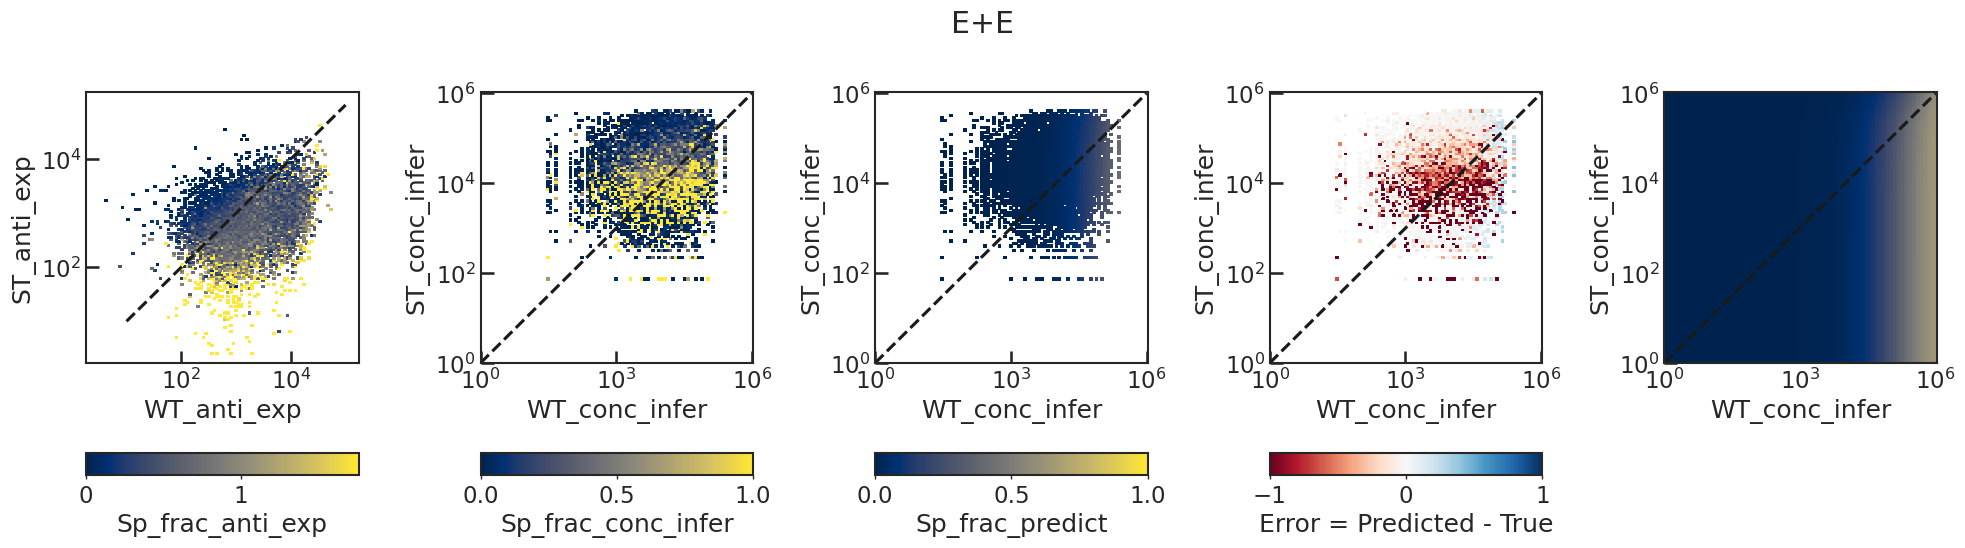

[5.62441115e-04 3.66375235e+00 2.91156961e-01]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


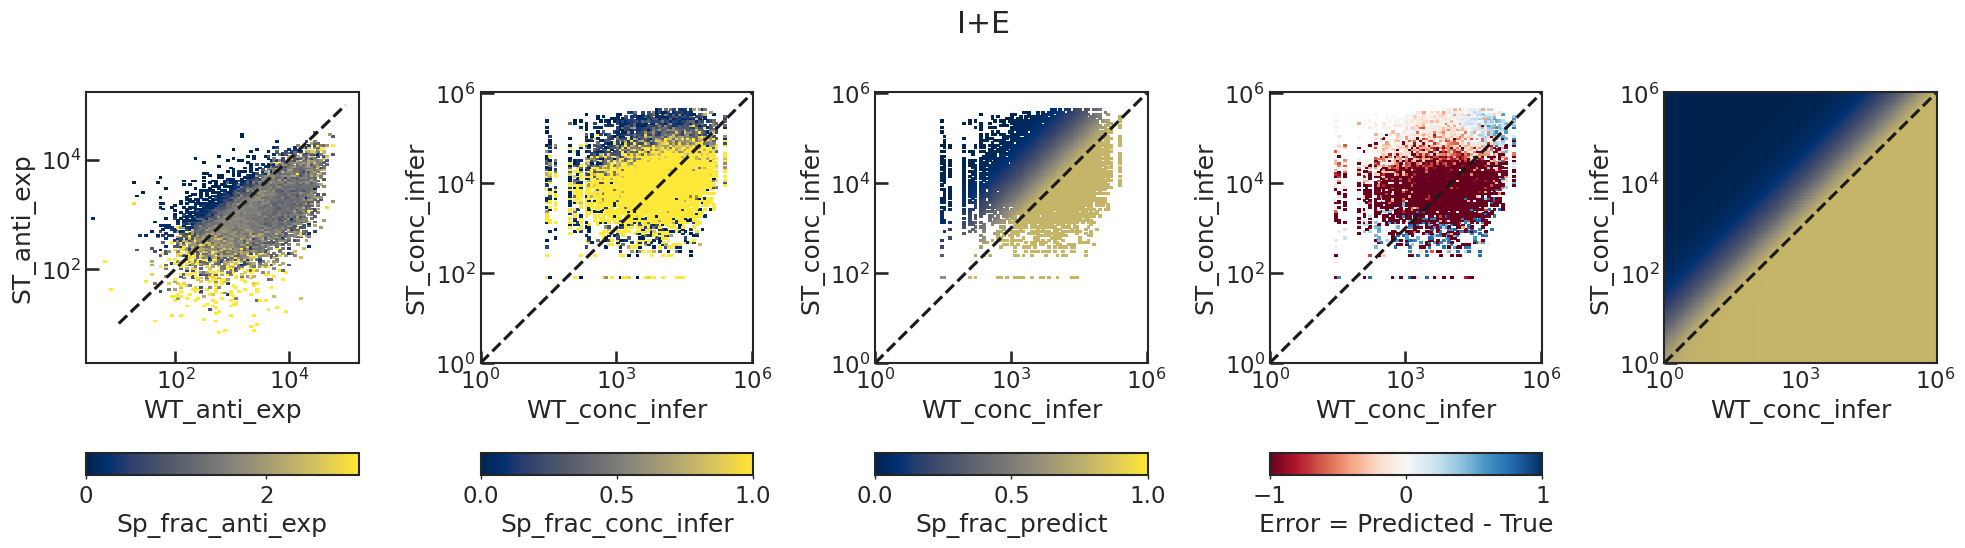

[5.62441115e-04 6.91786797e-07 1.74136511e+03]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


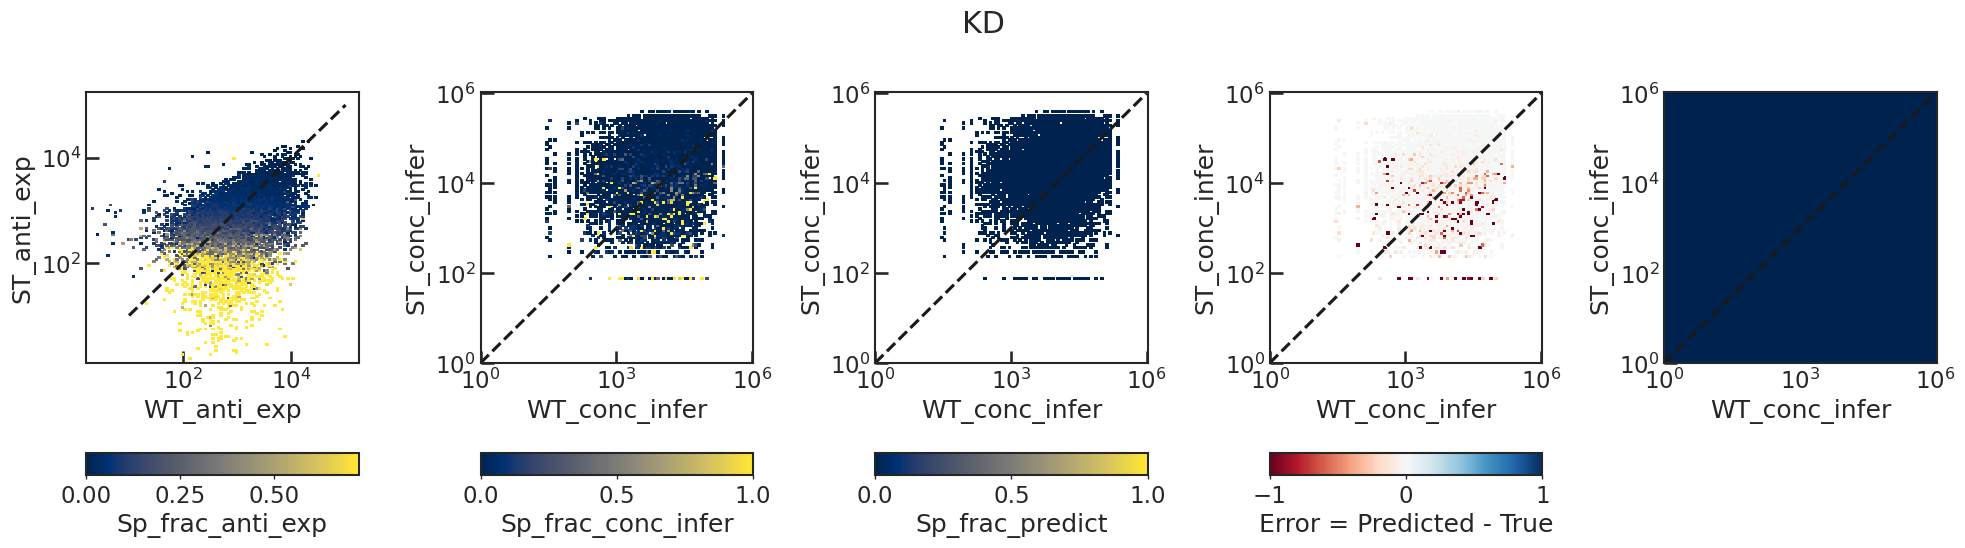

[5.62441115e-04 1.32380983e+00 1.74136511e+03]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


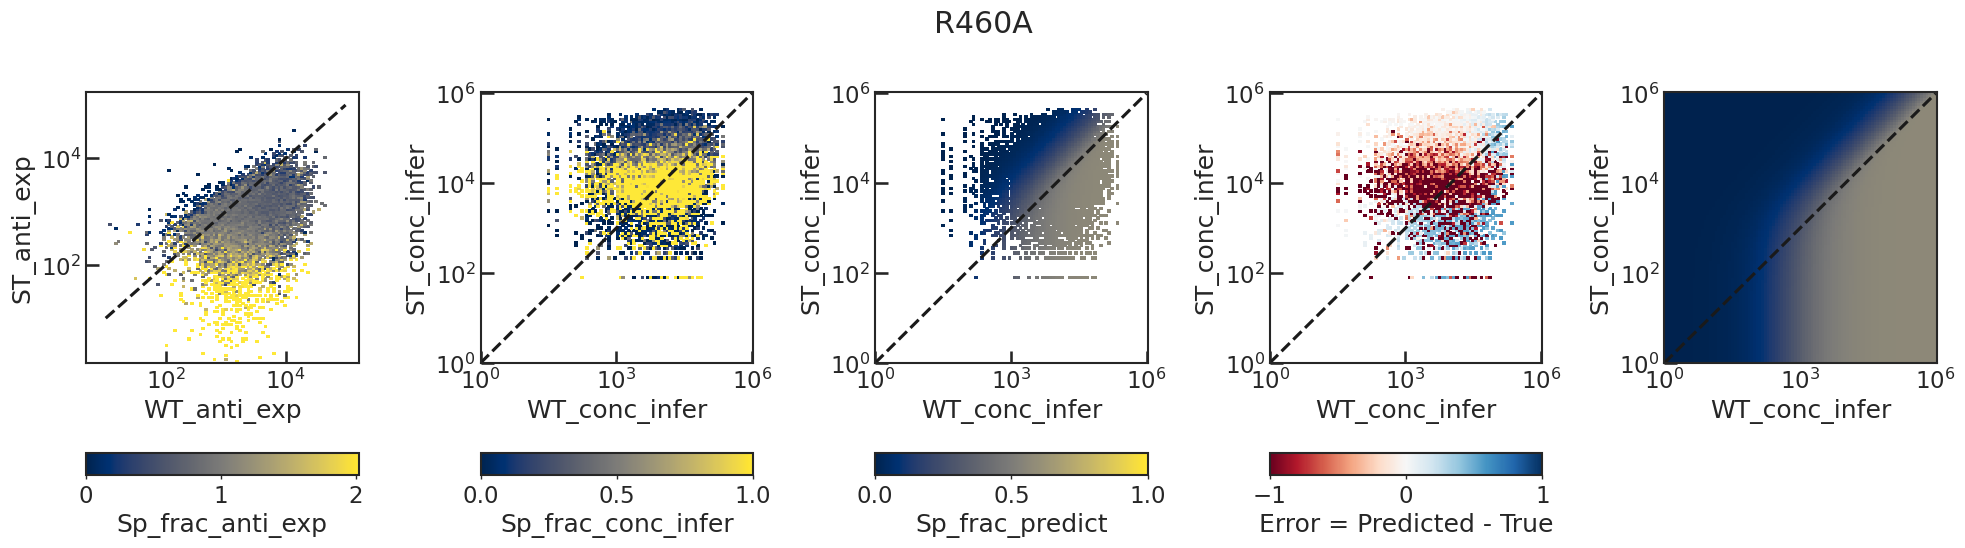

[5.62441115e-04 2.54125671e-01 1.74136511e+03]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


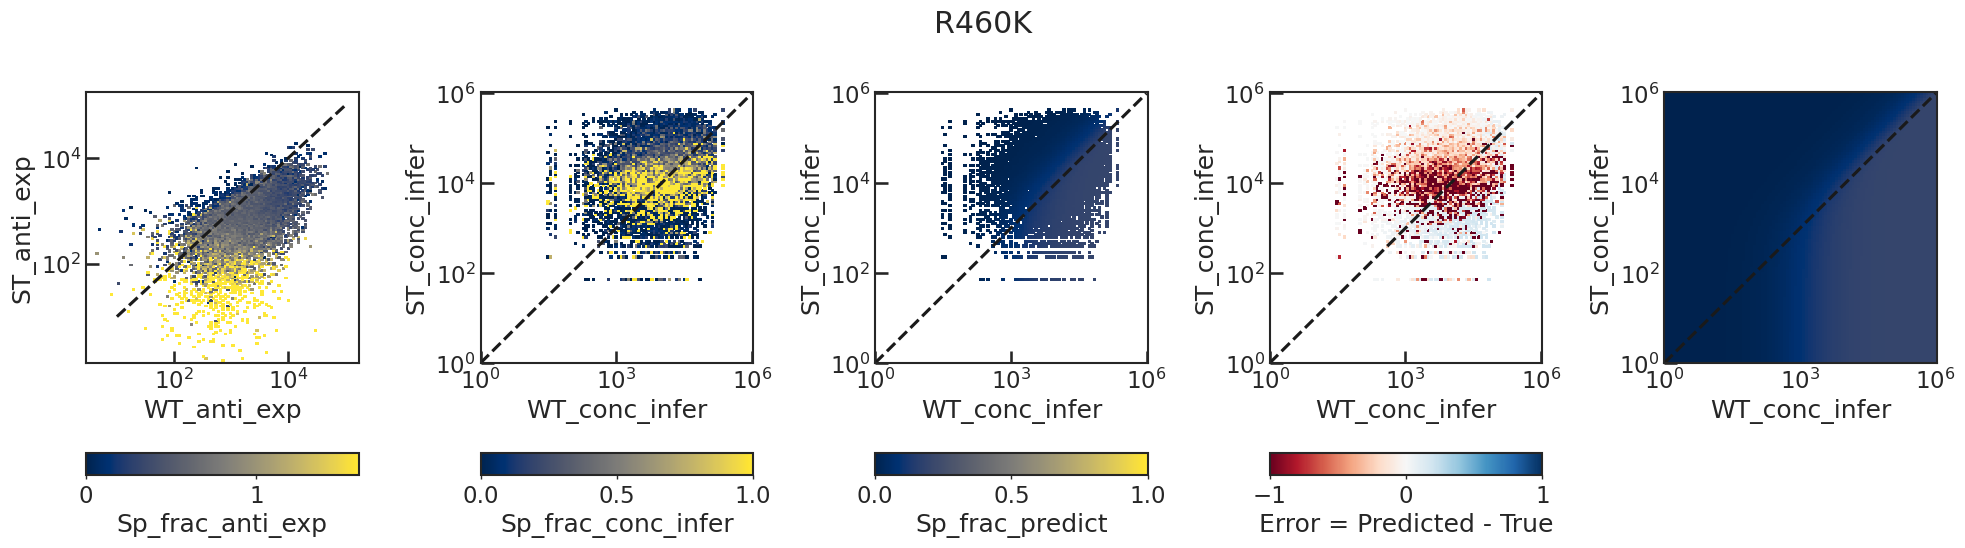

[5.62441115e-04 1.95785275e-02 1.74136511e+03]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


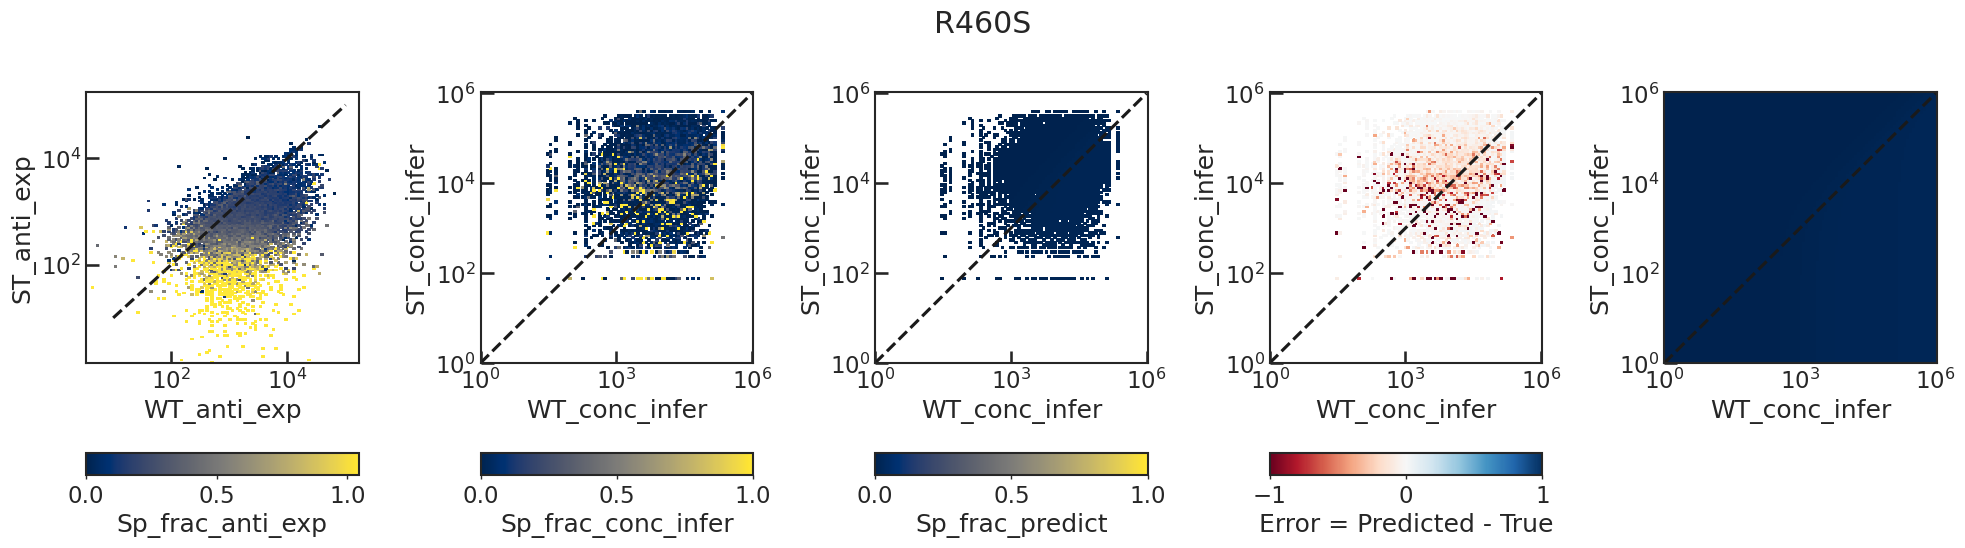

[5.62441115e-04 3.66375235e+00 6.73635460e+07]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


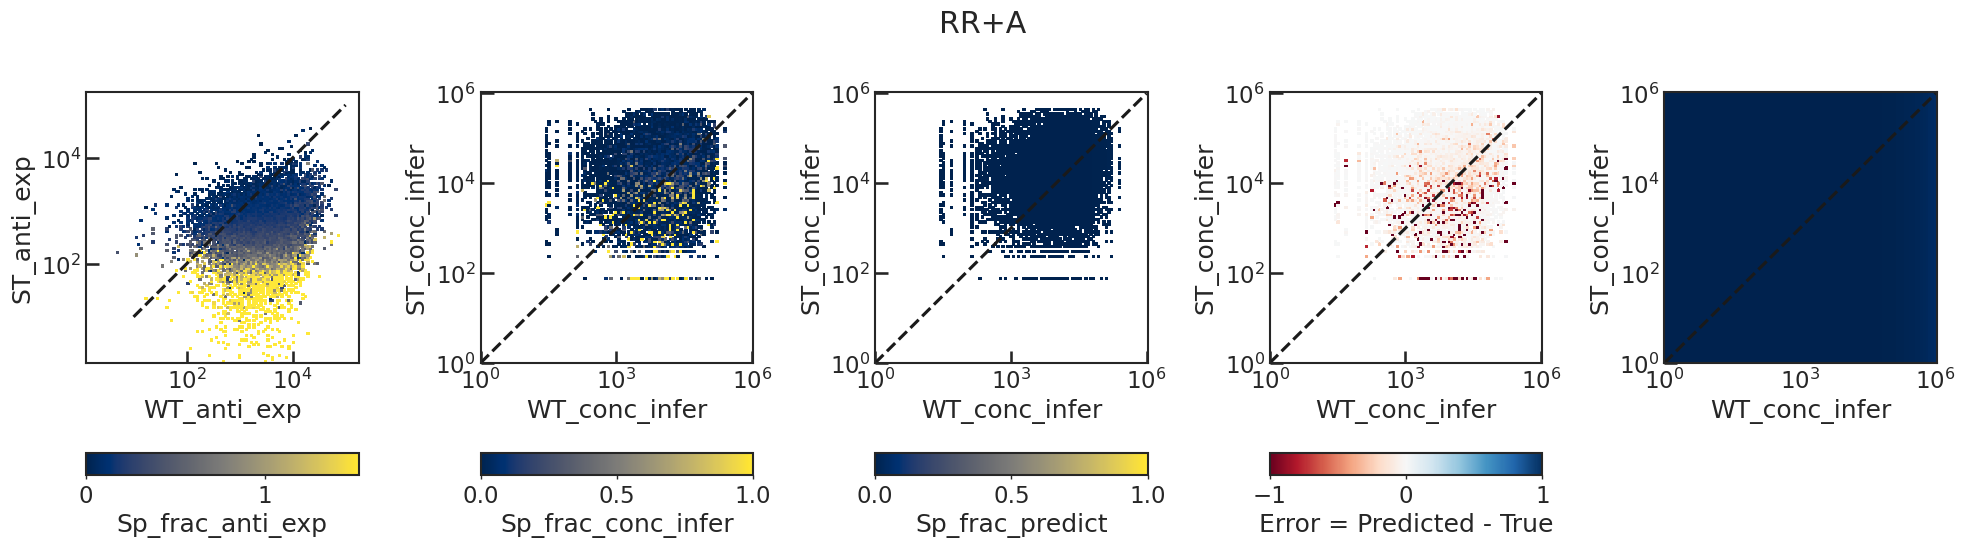

[5.62441115e-04 3.66375235e+00 1.33422146e+05]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


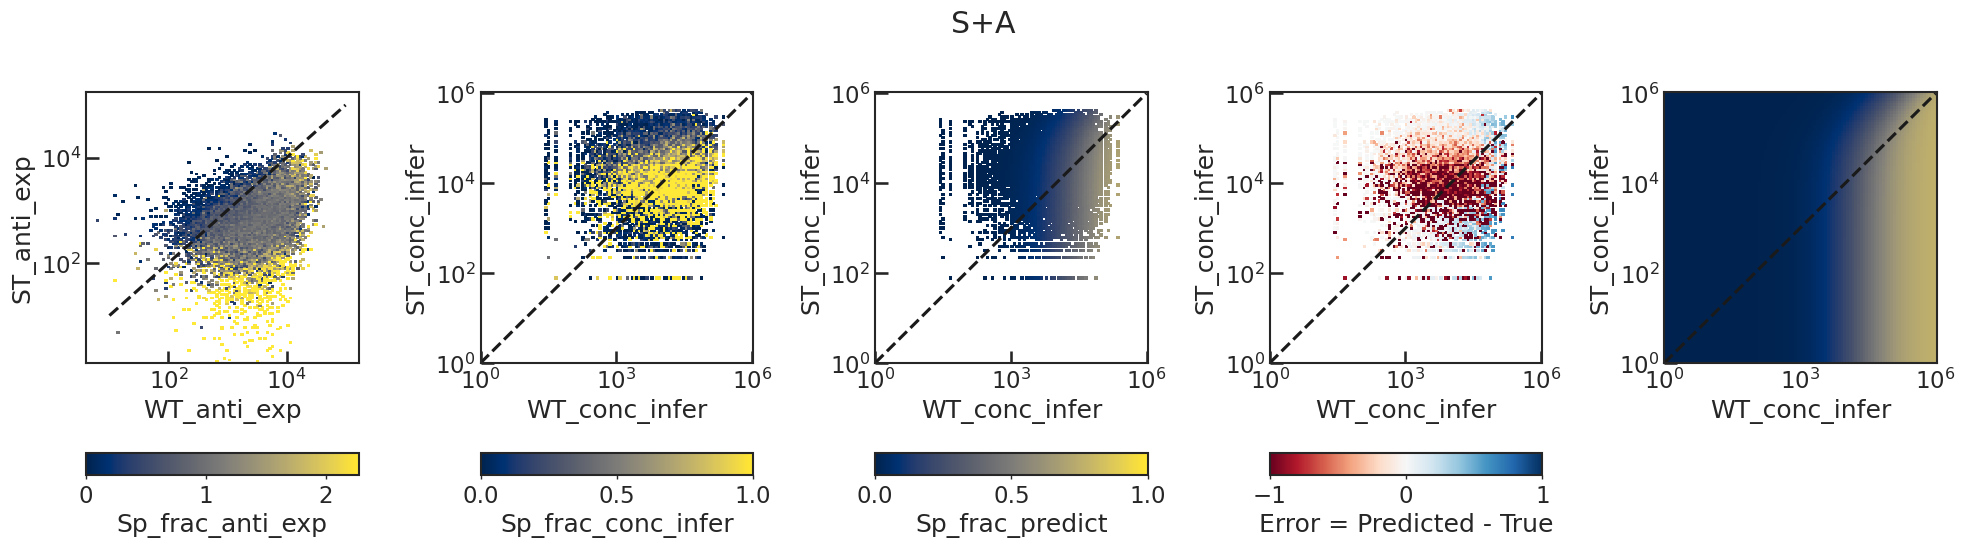

[5.62441115e-04 3.66375235e+00 3.47758711e+05]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


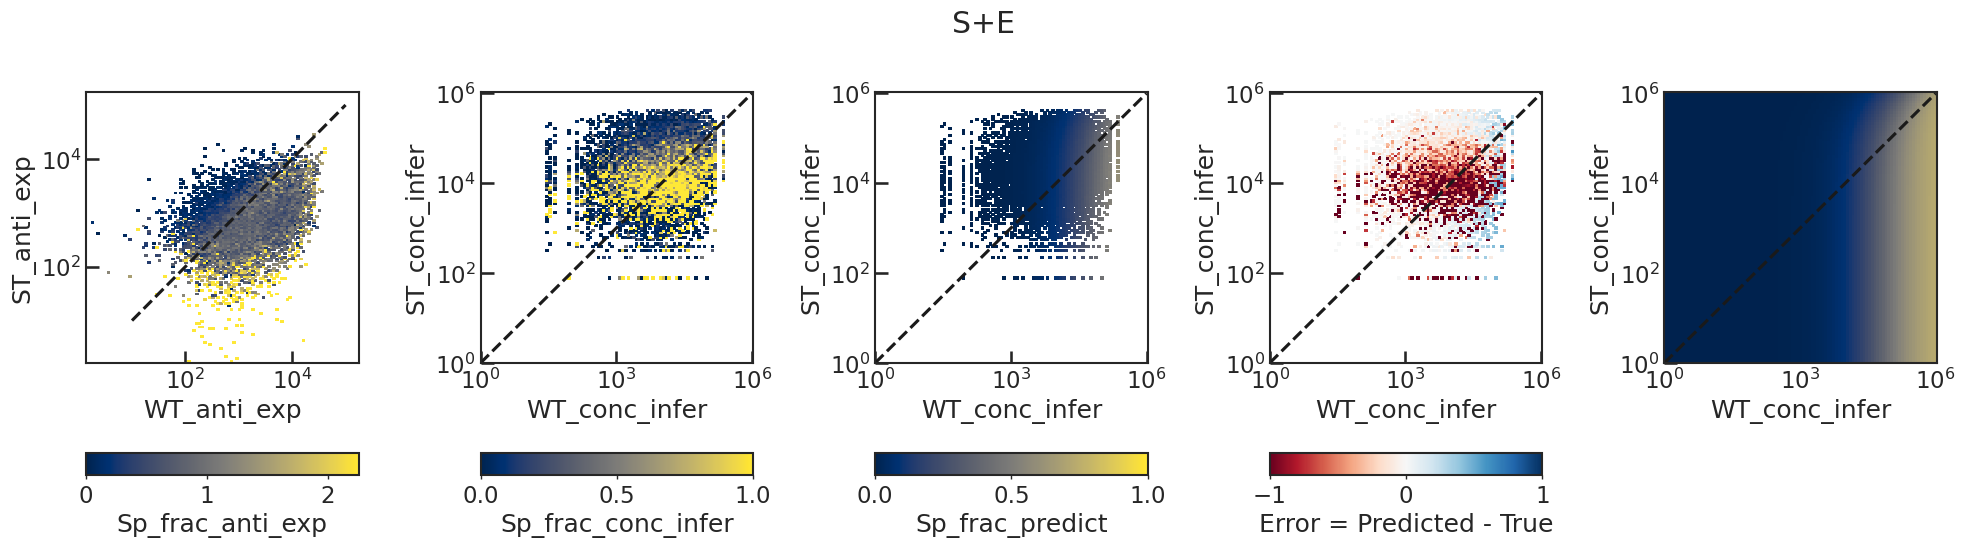

[5.62441115e-04 3.66375235e+00 1.74136511e+03]


/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jason/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


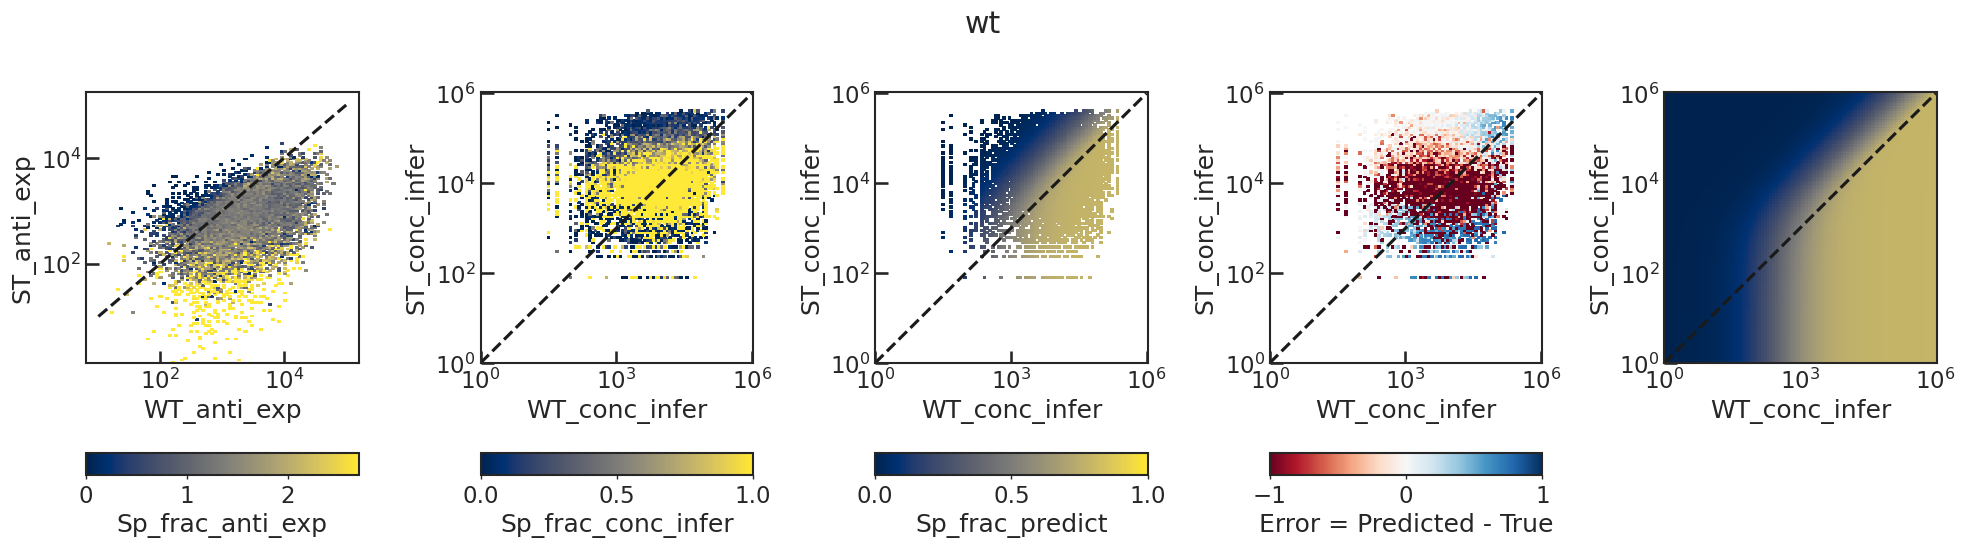

In [80]:



for i, (dataset, group) in enumerate(df.groupby("dataset")):
        
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[dataset][0:]]
    print(model_params)

    
    fig = plt.figure(figsize=(20, 4.5))
    
    axes = []
    
    fig.suptitle(dataset)
    
    ax = fig.add_subplot(1, 5, 1)
    axes.append(ax)
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=group['Sp_frac_anti_exp'].quantile(0.95))
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    
    
    
    
    ax = fig.add_subplot(1, 5, 2)
    axes.append(ax)
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins='auto', range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins='auto', range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_infer'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm2, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
        
    
    
    
    
    ax = fig.add_subplot(1, 5, 3, sharex=ax, sharey=ax)
    axes.append(ax)
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc_infer']), bins='auto', range=(0, 6))
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc_infer']), bins='auto', range=(0, 6))
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc_infer'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc_infer'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc_predict'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
    
    
    
    
    
    ax = fig.add_subplot(1, 5, 4, sharex=ax, sharey=ax)
    axes.append(ax)
    
    df_tmp['error'] = df_tmp['Sp_frac_conc_predict'] - df_tmp['Sp_frac_conc_infer']
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['error'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    cmap3=plt.cm.RdBu
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
        
    
    
    
    
    ax = fig.add_subplot(1, 5, 5, sharex=ax, sharey=ax)
    axes.append(ax)
    
    X, Y = np.meshgrid(np.logspace(0, 6, 100, base=10), np.logspace(0, 6, 100, base=10))
    
    
    SpT_GFP_predict = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array(model_params))[:, 0]
    
    Sp_frac_GFP_predict = SpT_GFP_predict / Y.flatten()
    
#     norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    ax.pcolormesh(X, Y, Sp_frac_GFP_predict.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')
    
    t = np.linspace(1e0, 1e6)
    ax.plot(t, t, 'k--')
    
#     ax.set_xlim(1e2, 1e6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc_infer')
    ax.set_ylabel('ST_conc_infer')
        
    
    
    
        
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc_infer")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_predict")
    
    
    bbox = axes[3].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Error = Predicted - True")

    

    plt.show()
    

['I+E', 'generic', 'S+A', 'S+E', 'E+E', 'RR+A']
[-0.5358728229980558, 3.240889839008906, 5.1252279211067195, 5.541278017905549, 5.977828340201713, 7.828424940459356]


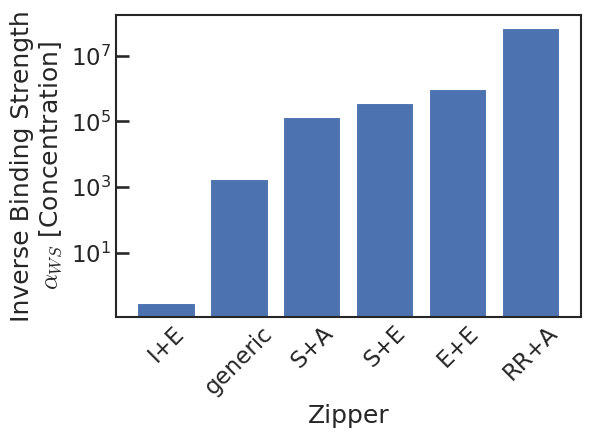

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

zipper_list = list(zippers.keys())

alphaWS_list = [res.x[zippers[zipper]] for zipper in zipper_list]

zipper_list = [x for _, x in sorted(zip(alphaWS_list, zipper_list))]
alphaWS_list = sorted(alphaWS_list)

print(zipper_list)
print(alphaWS_list)

ax.bar(zipper_list, 10**np.array(alphaWS_list))

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()

['KD', 'R460S', 'R460K', 'R460A', 'wt']
[-0.5358728229980558, 3.240889839008906, 5.1252279211067195, 5.541278017905549, 5.977828340201713, 7.828424940459356]


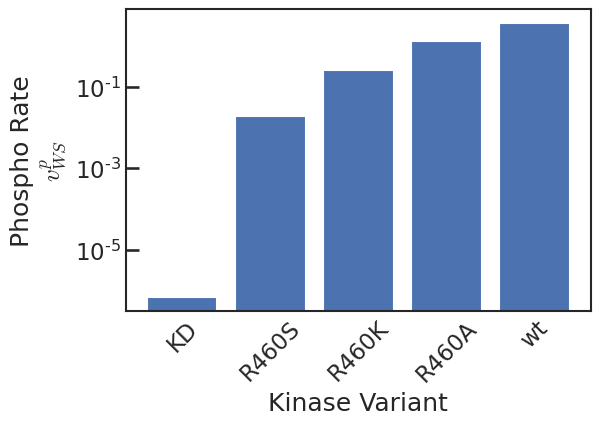

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

kinase_list = list(kinases.keys())

vWS_list = [res.x[kinases[kinase]] for kinase in kinase_list]

kinase_list = [x for _, x in sorted(zip(vWS_list, kinase_list))]
vWS_list = sorted(vWS_list)

print(kinase_list)
print(alphaWS_list)

ax.bar(kinase_list, 10**np.array(vWS_list))

ax.set_yscale('log')
ax.set_xlabel("Kinase Variant")
ax.set_ylabel("Phospho Rate\n" + r"$v^p_{WS}$")
plt.xticks(rotation=45)

plt.show()

[5.62441115e-04 3.66375235e+00 9.50229131e+05]
19811.612106


NameError: name 'lower' is not defined

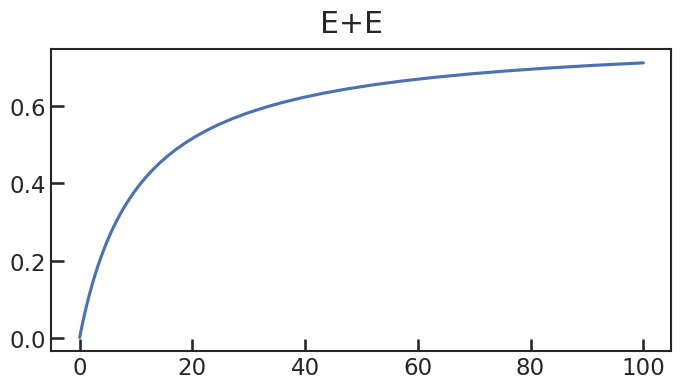

In [83]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    fig.suptitle(construct)
    
    ST_median = np.median(group['ST_conc_infer'])
    
    print(ST_median)
    
    ST = ST_median*np.ones(100)
    WT = np.logspace(np.log10(ST_median)-2, np.log10(ST_median)+2, 100, base=10)
    
    SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]
    
    ax.plot(WT/ST, SpT/ST, 'b', label="theory")
    
    
    
    
# #     df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
#     df_tmp = group.copy().dropna()
#     df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']
    
#     bin_labels, edges = pd.qcut(df_tmp['ratio'], 16, labels=False, retbins=True)
    
#     df_tmp['bin'] = bin_labels
    
#     Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].mean() 
#     Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].sem()
    
#     ax.errorbar((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, yerr=Sp_frac_err, fmt='g.-', label="experiment", ms=6.0)
    
    
    ST_upper = group['ST_conc_infer'].quantile(0.6)
    ST_lower = group['ST_conc_infer'].quantile(0.4)
    
    SpT_upper = group['SpT_conc_infer'].quantile(0.90)
    SpT_lower = group['SpT_conc_infer'].quantile(0.1)
    
    WT_upper = group['WT_conc_infer'].quantile(0.90)
    WT_lower = group['WT_conc_infer'].quantile(0.1)
    
    print(lower, upper)
    
    df_tmp = group.query("ST_conc_infer < @ST_upper and ST_conc_infer > @ST_lower and SpT_conc_infer < @SpT_upper and SpT_conc_infer > @SpT_lower and WT_conc_infer < @WT_upper and WT_conc_infer > @WT_lower").copy().dropna()
#     df_tmp = group.copy().dropna()
    df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']
    
    bin_labels, edges = pd.qcut(df_tmp['ratio'], 10, labels=False, retbins=True)
    
    df_tmp['bin'] = bin_labels
    
    Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].median() 
    Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].sem()
    
    ax.errorbar(np.sqrt(edges[1:]*edges[0:len(edges)-1]), Sp_frac, yerr=Sp_frac_err, fmt='g.-', label="experiment", ms=6.0)
    
    ax.set_xscale('log')
    
    ax.set_ylim(0, 1.0)
    
    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0, 0.0, 0.0))
    
    plt.show()

In [ ]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    fig.suptitle(construct)
    
    for ST_bin, groupb in group.groupby('ST_GFP_bin'):
        
        
        if ST_bin % 4 != 0:
            continue
            
            
        ST_median = np.median(groupb['ST_conc_infer'].values)
            
        print(ST_bin, ST_median)

    # #     noise_params = res.x[param_dict[construct][0:1]]
        model_params = 10**res.x[param_dict[construct][0:]]

    #     print(model_params)

      

        ST = ST_median*np.ones(100)
        WT = np.logspace(np.log10(ST_median)-2, np.log10(ST_median)+2, 100, base=10)

        SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]

        ax.plot(WT/ST, SpT/ST, 'b', label="theory")




        #     df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
        df_tmp = groupb.copy().dropna()
        df_tmp['ratio'] = df_tmp['WT_conc_infer'] / df_tmp['ST_conc_infer']

        bin_labels, edges = pd.qcut(df_tmp['ratio'], 16, labels=False, retbins=True)

        df_tmp['bin'] = bin_labels

        Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc_infer'].mean() 
        Sp_frac_err = df_tmp.groupby('bin')['Sp_frac_conc_infer'].sem()

        ax.errorbar((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, yerr=0, fmt='g.-', label="experiment", ms=6.0)


    ax.set_xscale('log')

    ax.set_ylim(0, 2.0)

    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")

    #     ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0, 0.0, 0.0))

    plt.show()